In [47]:
# Cell 1: Imports and Setup
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.precision', 4)

print("✓ Imports successful")


✓ Imports successful


# Sentiment Data Analysis: Data Understanding Phase

## Pipeline Architecture Overview

### Data Sources

**Central Bank Communications** (2021-2025):
- **Fed** (1,112 articles): Press releases, FOMC statements, speeches from federalreserve.gov
- **ECB** (841 articles): Monetary policy statements, speeches from ecb.europa.eu/press
- **BoE** (1,029 articles): Policy summaries, speeches from bankofengland.co.uk  
- **GDELT** (0 articles): Event-based schema requires separate preprocessor - in progress

**Total Dataset**: 2,982 articles across 180 monthly partitions

---

### Why These Sources?

Central banks are the primary drivers of FX market sentiment through:
- **Policy Signals**: Forward guidance on interest rates directly impacts currency valuations
- **Tone Analysis**: Hawkish/dovish language shifts market expectations before actual policy changes
- **Institutional Authority**: Official statements carry more weight than market commentary

---

### Processing Pipeline

**Bronze → Silver Architecture**:

1. **Bronze Layer** (`data/raw/news/{source}/*.jsonl`): Immutable raw data in JSONL format
   - **Why JSONL?** Streaming-friendly, append-only, easy to version control line-by-line

2. **Silver Layer** (`data/processed/sentiment/source={source}/year={year}/month={month}/*.parquet`): Sentiment-analyzed data
   - **Why FinBERT?** Domain-specific model fine-tuned on financial text (more accurate than general BERT on monetary policy language)
   - **Why Hive Partitioning?** Enables efficient date-range and source-specific queries without loading entire dataset
   - **Sentiment Score**: `P(positive) - P(negative)` ∈ [-1.0, +1.0]

---

### Known Limitations

- **GDELT Integration**: Different schema (events vs documents) - custom preprocessor pending
- **Missing Speakers**: 62.8% lack explicit speaker attribution (documents without named authors)
- **Collection Gaps**: Monthly variations reflect actual publication frequency, not scraper issues

---

*This notebook explores patterns, distributions, and characteristics in the sentiment-analyzed data to inform future modeling decisions.*


In [67]:
# Cell 2: Configuration
# Define paths according to your project structure
BASE_PATH = Path(r"D:\SCRIPTS\FX-AlphaLab\data\processed\sentiment")

# Data coverage
SOURCES = ["fed", "ecb", "boe", "gdelt"]
YEARS = range(2021, 2026)  # 2021-2025
MONTHS = range(1, 13)

# Expected schema (actual column is 'currency' not 'pair')
EXPECTED_COLUMNS = [
    'timestamp_utc', 'article_id', 'currency', 'headline',
    'sentiment_score', 'sentiment_label', 'document_type',
    'speaker', 'source', 'url'
]

print(f"Base path: {BASE_PATH}")
print(f"Sources: {SOURCES}")
print(f"Coverage: {min(YEARS)}-{max(YEARS)}")

Base path: D:\SCRIPTS\FX-AlphaLab\data\processed\sentiment
Sources: ['fed', 'ecb', 'boe', 'gdelt']
Coverage: 2021-2025


In [68]:
# Cell 3: Data Loading Function
def load_sentiment_data(
    sources: list[str] = SOURCES,
    years: list[int] | None = None,
    months: list[int] | None = None,
    validate: bool = True
) -> pd.DataFrame:
    """
    Load sentiment data from Hive-partitioned Parquet files.
    
    Parameters:
    -----------
    sources : List[str]
        List of sources to load (fed, ecb, boe, gdelt)
    years : List[int], optional
        Years to load. If None, loads all available years
    months : List[int], optional
        Months to load. If None, loads all months
    validate : bool
        Whether to validate schema and data quality
        
    Returns:
    --------
    pd.DataFrame
        Combined sentiment data
    """

    if years is None:
        years = list(YEARS)
    if months is None:
        months = list(MONTHS)

    dataframes = []
    missing_partitions = []

    for source in sources:
        for year in years:
            for month in months:
                # Construct partition path
                partition_path = (
                    BASE_PATH /
                    f"source={source}" /
                    f"year={year}" /
                    f"month={month:02d}" /
                    "sentiment_cleaned.parquet"
                )

                if partition_path.exists():
                    try:
                        df = pd.read_parquet(partition_path)
                        dataframes.append(df)
                    except Exception as e:
                        print(f"⚠️  Error reading {partition_path}: {e}")
                else:
                    missing_partitions.append(
                        f"{source}/{year}/{month:02d}"
                    )

    if not dataframes:
        raise ValueError("No data files found. Check BASE_PATH and data availability.")

    # Combine all partitions
    df_combined = pd.concat(dataframes, ignore_index=True)

    # Report statistics
    print(f"✓ Loaded {len(dataframes)} partitions")
    print(f"✓ Total records: {len(df_combined):,}")
    print(f"✓ Date range: {df_combined['timestamp_utc'].min()} to {df_combined['timestamp_utc'].max()}")
    print(f"✓ Sources: {df_combined['source'].unique().tolist()}")

    if missing_partitions:
        print(f"\nℹ️  Missing {len(missing_partitions)} partitions (expected if data collection incomplete)")

    # Validate if requested
    if validate:
        _validate_schema(df_combined)
        _validate_data_quality(df_combined)

    return df_combined


def _validate_schema(df: pd.DataFrame) -> None:
    """Validate DataFrame schema matches expected structure."""
    missing_cols = set(EXPECTED_COLUMNS) - set(df.columns)
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    print("✓ Schema validation passed")


def _validate_data_quality(df: pd.DataFrame) -> None:
    """Validate data quality constraints."""
    issues = []

    # Check sentiment_score range
    if not df['sentiment_score'].between(-1.0, 1.0).all():
        issues.append("sentiment_score outside [-1.0, 1.0] range")

    # Check sentiment_label values
    valid_labels = {'positive', 'neutral', 'negative'}
    invalid_labels = set(df['sentiment_label'].unique()) - valid_labels
    if invalid_labels:
        issues.append(f"Invalid sentiment_label values: {invalid_labels}")

    # Check for duplicates
    duplicates = df.duplicated(subset=['timestamp_utc', 'article_id']).sum()
    if duplicates > 0:
        issues.append(f"{duplicates:,} duplicate records found")

    if issues:
        print("⚠️  Data quality issues detected:")
        for issue in issues:
            print(f"   - {issue}")
    else:
        print("✓ Data quality validation passed")

print("✓ Functions defined")


✓ Functions defined


In [69]:
# Cell 4: Load All Data
df_sentiment = load_sentiment_data()

# Convert timestamp to datetime
df_sentiment['timestamp_utc'] = pd.to_datetime(df_sentiment['timestamp_utc'])

# Sort by timestamp
df_sentiment = df_sentiment.sort_values('timestamp_utc').reset_index(drop=True)

print(f"\n{'='*60}")
print(f"Dataset shape: {df_sentiment.shape}")
print(f"Memory usage: {df_sentiment.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


✓ Loaded 180 partitions
✓ Total records: 2,982
✓ Date range: 2021-01-01T00:00:00Z to 2025-12-30T00:00:00Z
✓ Sources: ['fed', 'ecb', 'boe']

ℹ️  Missing 60 partitions (expected if data collection incomplete)
✓ Schema validation passed
✓ Data quality validation passed

Dataset shape: (2982, 10)
Memory usage: 1.89 MB


In [70]:
# Cell 5: Quick Data Overview
print("First few records:")
display(df_sentiment.head())

print("\nData types:")
display(df_sentiment.dtypes)

print("\nBasic statistics:")
display(df_sentiment.describe(include='all'))


First few records:


,timestamp_utc,article_id,currency,headline,document_type,speaker,source,url,sentiment_score,sentiment_label
0,2021-01-01 00:00:00+00:00,18a9802ef8d878ae,EUR,Hearing of the Committee on Economic and Monetary Affairs of the European Parliament,speech,Christine Lagarde,ecb,https://www.ecb.europa.eu/press/key/date/2021/html/ecb.sp.210927~c1957025ab.en.html,0.0,neutral
1,2021-01-01 00:00:00+00:00,ee000d04a854a4e4,EUR,The NGFS Glasgow Declaration – From a coalition of the willing to a coalition of the committed,speech,Frank Elderson,ecb,https://www.ecb.europa.eu/press/key/date/2021/html/ecb.sp211103_1~981d1ed885.en.html,0.0,neutral
2,2021-01-01 00:00:00+00:00,81c0a96ef5aa2ed9,EUR,Monetary policy and financial stability,speech,Isabel Schnabel,ecb,https://www.ecb.europa.eu/press/key/date/2021/html/ecb.sp211208_2~97c82f5cfb.en.html,0.0,neutral
3,2021-01-01 00:00:00+00:00,99d776350c356a36,EUR,Results of the September 2021 survey on credit terms and conditions in euro-denominated securiti...,press_release,None,ecb,https://www.ecb.europa.eu/press/pr/date/2021/html/ecb.pr211029_1~02d88a552f.en.html,0.0,neutral
4,2021-01-01 00:00:00+00:00,639dec8de702d1f0,EUR,“Hic sunt leones” – open research questions on the international dimension of central bank digit...,speech,Fabio Panetta,ecb,https://www.ecb.europa.eu/press/key/date/2021/html/ecb.sp211019_1~b91b5f9595.en.html,0.0,neutral



Data types:


timestamp_utc      datetime64[ns, UTC]
article_id                      object
currency                        object
headline                        object
document_type                   object
speaker                         object
source                          object
url                             object
sentiment_score                float64
sentiment_label                 object
dtype: object


Basic statistics:


,timestamp_utc,article_id,currency,headline,document_type,speaker,source,url,sentiment_score,sentiment_label
count,2982,2982,2982,2982,2982,1109,2982,2982,2982.0000,2982
unique,NaN,2982,3,2724,9,95,3,2982,NaN,3
top,NaN,be96997a9aadb0f4,USD,"Christine Lagarde, Luis de Guindos: Monetary policy statement (with Q&A)",press_release,Christine Lagarde,fed,/newsevents/pressreleases/monetary20251230a.htm,NaN,neutral
freq,NaN,1,1112,36,918,123,1112,1,NaN,2585
mean,2023-06-23 11:17:21.367203072+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0279,NaN
min,2021-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.9710,NaN
25%,2022-03-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN
50%,2023-06-20 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN
75%,2024-10-07 18:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN
max,2025-12-30 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9574,NaN


In [71]:
# Cell 6: Source-Specific Loading (Optional)
# Load only specific sources if needed
def load_by_source(source: str, years: list[int] | None = None) -> pd.DataFrame:
    """Load data for a specific source."""
    df = load_sentiment_data(sources=[source], years=years, validate=False)
    df['timestamp_utc'] = pd.to_datetime(df['timestamp_utc'])
    return df.sort_values('timestamp_utc').reset_index(drop=True)

# Example: Load only Fed data
# df_fed = load_by_source('fed')
# df_ecb = load_by_source('ecb', years=[2024, 2025])

print("✓ Source-specific loading function ready")


✓ Source-specific loading function ready


In [72]:
# Cell 6: Data Overview & Missing Values Analysis
print("="*60)
print("DATA QUALITY ASSESSMENT")
print("="*60)

# Missing values
print("\nMissing Values:")
missing = df_sentiment.isnull().sum()
missing_pct = (missing / len(df_sentiment) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

# Data types
print("\n" + "="*60)
print("Data Types:")
print(df_sentiment.dtypes)

# Unique values per column
print("\n" + "="*60)
print("Cardinality (Unique Values):")
for col in df_sentiment.columns:
    print(f"{col:20s}: {df_sentiment[col].nunique():>6,} unique values")


DATA QUALITY ASSESSMENT

Missing Values:
         Missing Count  Percentage
speaker           1873       62.81

Data Types:
timestamp_utc      datetime64[ns, UTC]
article_id                      object
currency                        object
headline                        object
document_type                   object
speaker                         object
source                          object
url                             object
sentiment_score                float64
sentiment_label                 object
dtype: object

Cardinality (Unique Values):
timestamp_utc       :  1,139 unique values
article_id          :  2,982 unique values
currency            :      3 unique values
headline            :  2,724 unique values
document_type       :      9 unique values
speaker             :     95 unique values
source              :      3 unique values
url                 :  2,982 unique values
sentiment_score     :    370 unique values
sentiment_label     :      3 unique values


In [73]:
# Cell 7: Visualization Setup

import matplotlib.pyplot as plt
import seaborn as sns

# Set professional style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Custom colors for sources
SOURCE_COLORS = {
    'fed': '#1f77b4',  # Blue
    'ecb': '#ff7f0e',  # Orange
    'boe': '#2ca02c',  # Green
    'gdelt': '#d62728'  # Red
}

# Figure size standard
FIGSIZE_WIDE = (16, 6)
FIGSIZE_SQUARE = (12, 8)
FIGSIZE_TALL = (14, 10)

print("✓ Visualization setup complete")


✓ Visualization setup complete


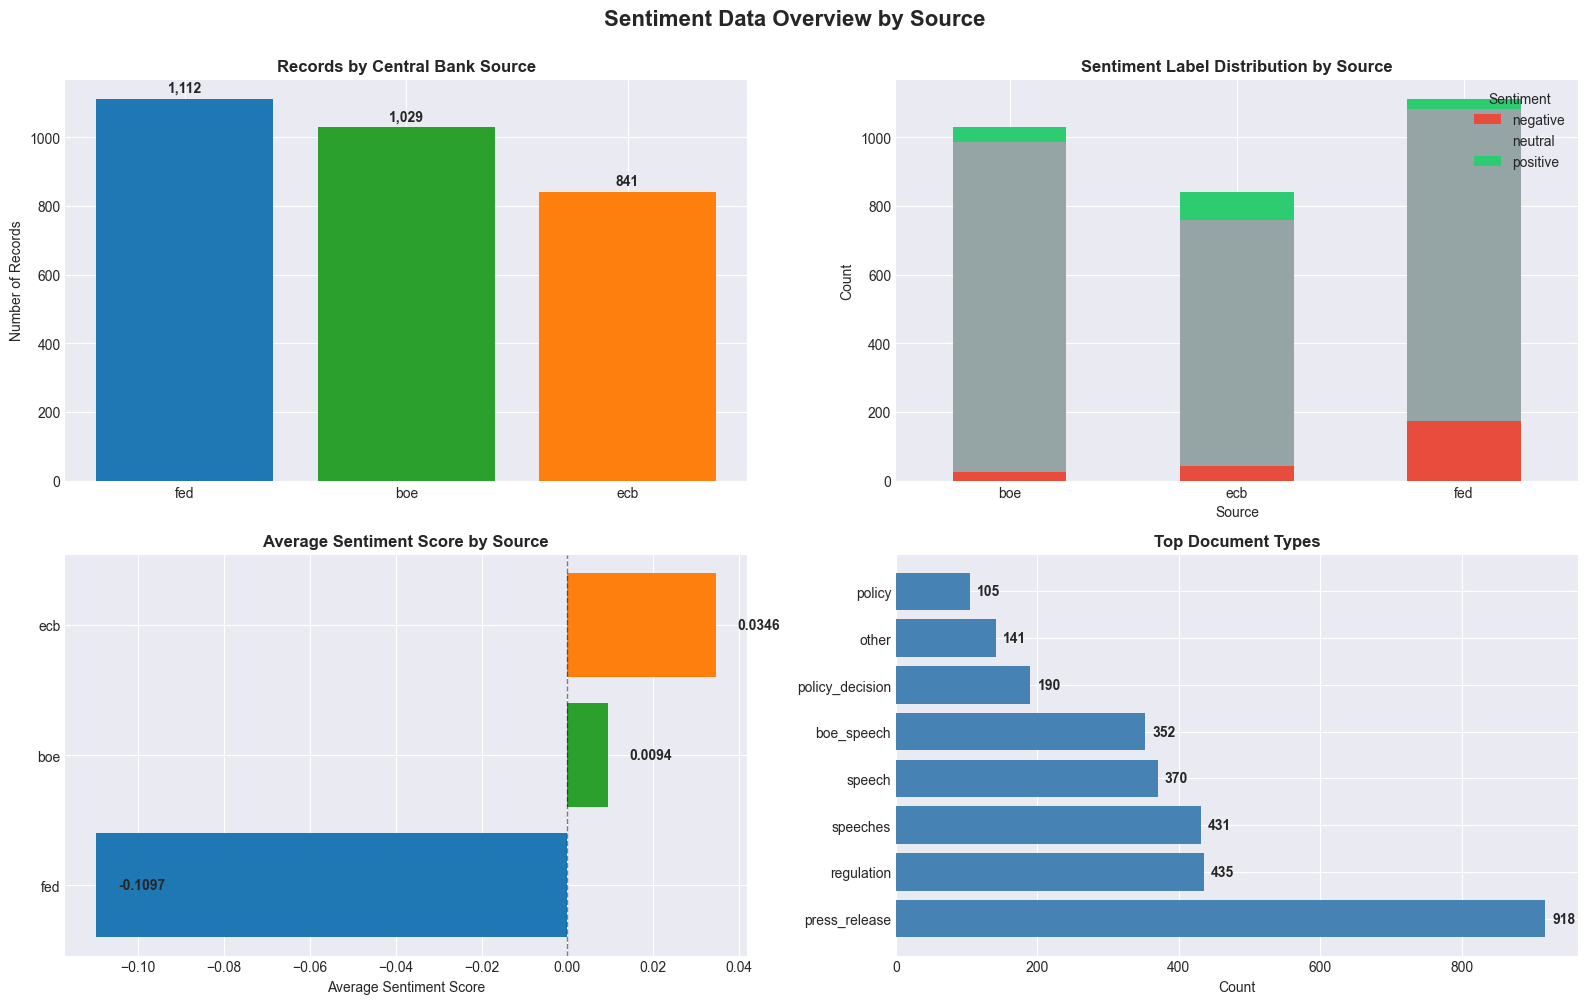


✓ Overview statistics visualized


In [74]:
# Cell 8: Overview Statistics by Source
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Sentiment Data Overview by Source', fontsize=16, fontweight='bold', y=1.00)

# 1. Record count by source
source_counts = df_sentiment['source'].value_counts()
axes[0, 0].bar(source_counts.index, source_counts.values,
               color=[SOURCE_COLORS.get(s, 'gray') for s in source_counts.index])
axes[0, 0].set_title('Records by Central Bank Source', fontweight='bold')
axes[0, 0].set_ylabel('Number of Records')
for i, (source, count) in enumerate(source_counts.items()):
    axes[0, 0].text(i, count + 20, f'{count:,}', ha='center', fontweight='bold')

# 2. Sentiment label distribution by source
label_counts = pd.crosstab(df_sentiment['source'], df_sentiment['sentiment_label'])
label_counts.plot(kind='bar', stacked=True, ax=axes[0, 1],
                  color=['#e74c3c', '#95a5a6', '#2ecc71'])
axes[0, 1].set_title('Sentiment Label Distribution by Source', fontweight='bold')
axes[0, 1].set_xlabel('Source')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend(title='Sentiment', loc='upper right')
axes[0, 1].tick_params(axis='x', rotation=0)

# 3. Average sentiment score by source
avg_sentiment = df_sentiment.groupby('source')['sentiment_score'].mean().sort_values()
colors_avg = [SOURCE_COLORS.get(s, 'gray') for s in avg_sentiment.index]
axes[1, 0].barh(avg_sentiment.index, avg_sentiment.values, color=colors_avg)
axes[1, 0].set_title('Average Sentiment Score by Source', fontweight='bold')
axes[1, 0].set_xlabel('Average Sentiment Score')
axes[1, 0].axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
for i, (source, score) in enumerate(avg_sentiment.items()):
    axes[1, 0].text(score + 0.005, i, f'{score:.4f}', va='center', fontweight='bold')

# 4. Document type distribution
doc_counts = df_sentiment['document_type'].value_counts().head(8)
axes[1, 1].barh(doc_counts.index, doc_counts.values, color='steelblue')
axes[1, 1].set_title('Top Document Types', fontweight='bold')
axes[1, 1].set_xlabel('Count')
for i, (doc, count) in enumerate(doc_counts.items()):
    axes[1, 1].text(count + 10, i, f'{count}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Overview statistics visualized")


## 📊 Key Insights: Overview Statistics

### Findings:

1. **Source Imbalance**: Fed (1,112) > BoE (1,029) > ECB (841)  
   - Fed publishes more frequently, particularly during policy-active periods
   - All three sources have sufficient volume for meaningful analysis

2. **Fed Negative Bias**: Average sentiment -0.11 (vs. ECB +0.03, BoE +0.01)  
   - Period covers 2021-2025: inflation surge, aggressive rate hikes, "higher for longer" rhetoric
   - Fed language historically more cautious/technical than ECB/BoE
   - Genuine hawkish tone vs. FinBERT interpretation - requires validation

3. **Document Type Distribution**: Press releases (918) dominate over speeches (431)
   - Press releases are policy-official statements (higher signal value)
   - Speeches may contain personal views or contextual commentary (lower signal reliability)

4. **Label Concentration**: ~90% neutral classification
   - FinBERT's behavior on formal institutional text - conservative classification
   - Central banks use carefully calibrated language to avoid market overreaction

---

### Why This Matters:

**Design Decision Context**:
- **Source weighting** will need to account for publication volume differences (Fed dominance could skew multi-source aggregation)
- **Document type hierarchy** should reflect signal quality (press releases > speeches > interviews)
- **Fed calibration** may require domain-specific adjustments if FinBERT systematically misreads Fed's technical language
- **Neutral cluster** suggests strong sentiment signals (+/- 0.3+) are rare but highly significant when they occur


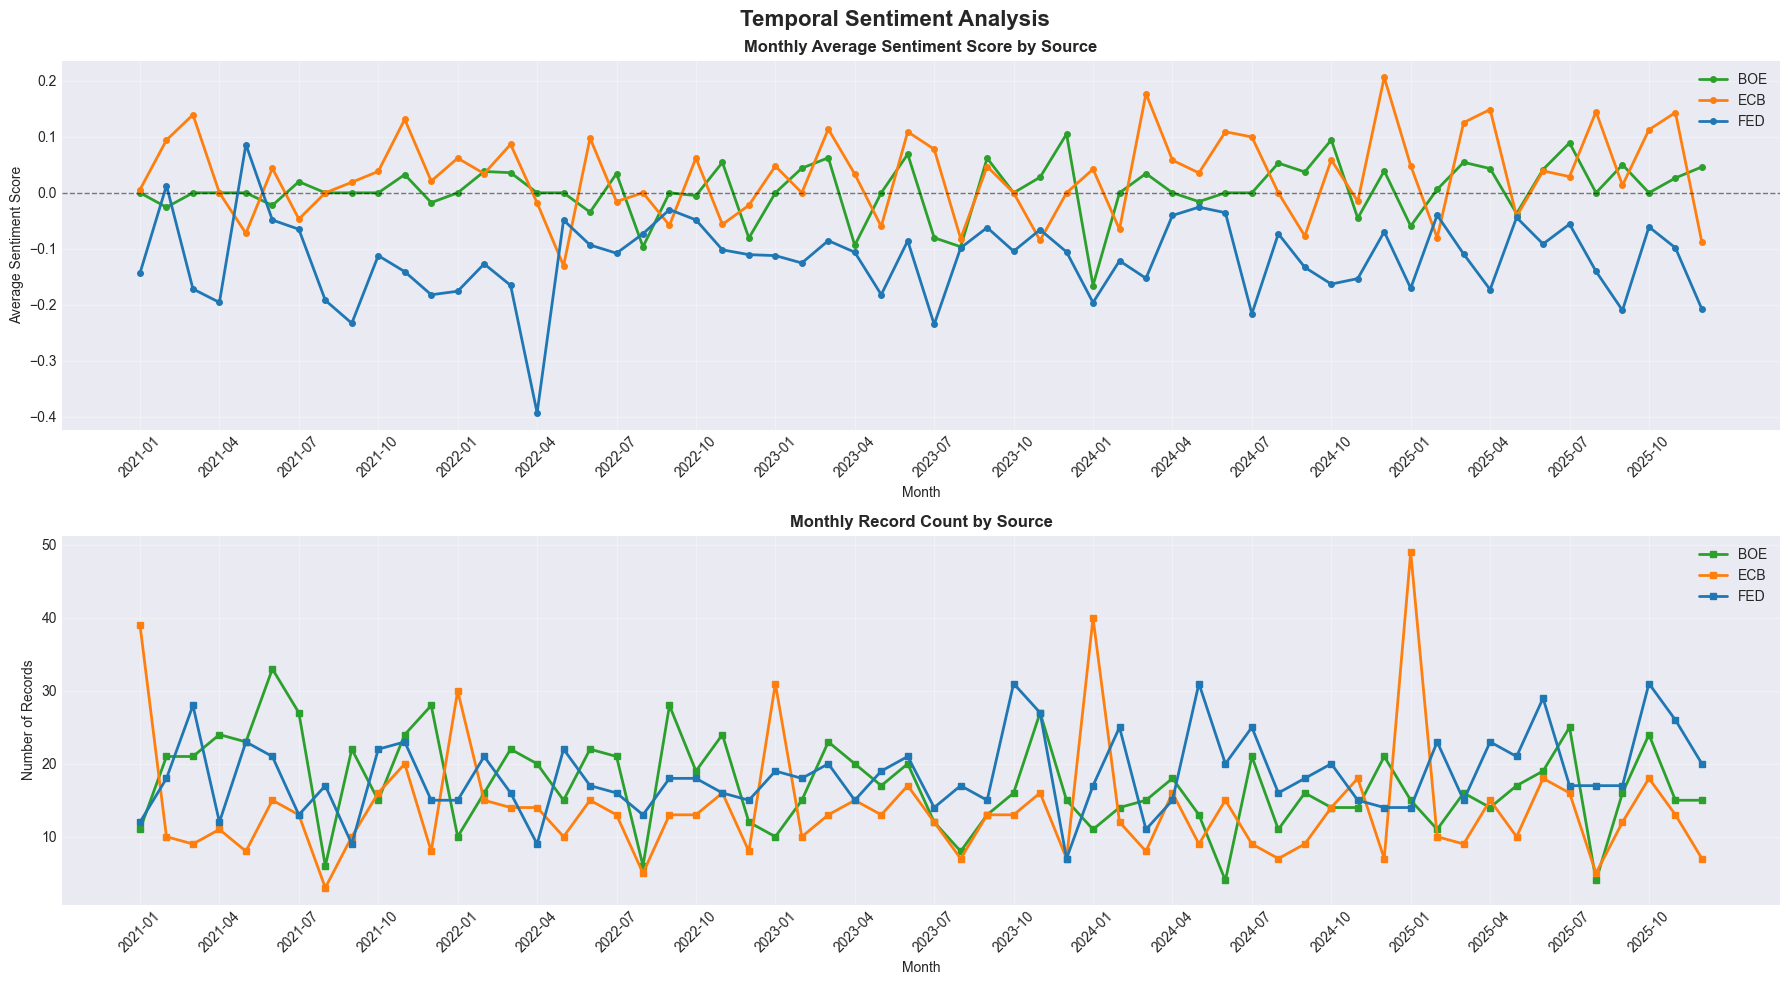


✓ Temporal analysis complete


In [75]:
# Cell 9: Temporal Analysis - Sentiment Over Time
# Add temporal features
df_sentiment['year'] = df_sentiment['timestamp_utc'].dt.year
df_sentiment['month'] = df_sentiment['timestamp_utc'].dt.month
df_sentiment['year_month'] = df_sentiment['timestamp_utc'].dt.to_period('M')

# Monthly aggregation
monthly_sentiment = df_sentiment.groupby(['year_month', 'source']).agg({
    'sentiment_score': 'mean',
    'article_id': 'count'
}).rename(columns={'article_id': 'count'}).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(18, 10))
fig.suptitle('Temporal Sentiment Analysis', fontsize=16, fontweight='bold')

# 1. Monthly average sentiment by source
for source in monthly_sentiment['source'].unique():
    source_data = monthly_sentiment[monthly_sentiment['source'] == source]
    axes[0].plot(source_data['year_month'].astype(str),
                 source_data['sentiment_score'],
                 marker='o', label=source.upper(),
                 color=SOURCE_COLORS.get(source, 'gray'),
                 linewidth=2, markersize=4)

axes[0].set_title('Monthly Average Sentiment Score by Source', fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Average Sentiment Score')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0].legend(loc='best', framealpha=0.9)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)
# Show fewer x-axis labels for readability
n_labels = len(monthly_sentiment['year_month'].unique())
axes[0].set_xticks(range(0, n_labels, max(1, n_labels//20)))

# 2. Monthly record count by source
for source in monthly_sentiment['source'].unique():
    source_data = monthly_sentiment[monthly_sentiment['source'] == source]
    axes[1].plot(source_data['year_month'].astype(str),
                 source_data['count'],
                 marker='s', label=source.upper(),
                 color=SOURCE_COLORS.get(source, 'gray'),
                 linewidth=2, markersize=4)

axes[1].set_title('Monthly Record Count by Source', fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Records')
axes[1].legend(loc='best', framealpha=0.9)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xticks(range(0, n_labels, max(1, n_labels//20)))

plt.tight_layout()
plt.show()

print("\n✓ Temporal analysis complete")


## 📈 Key Insights: Temporal Analysis

### Findings:

1. **Publication Frequency**: Monthly counts range from 26-78 articles
   - Reflects policy cycle intensity (more communication during crisis periods)
   - Fed shows consistent volume, ECB/BoE more variable

2. **Fed Persistently Negative**: -0.11 average throughout 2021-2025
   - 2022 Q2 dip to -0.4 during peak rate hike cycle
   - Reflects "higher for longer" rhetoric and restrictive policy stance

3. **ECB Volatility**: Large monthly swings (+0.2 to -0.1)
   - Smaller article counts (8-30/month) amplify impact of individual speeches
   - European fragmentation creates mixed messaging

4. **2022-2023 Global Decline**: All sources trend negative
   - Inflation surge, coordinated rate hikes, growth concerns
   - 2024 recovery as inflation stabilizes

---

### Why This Matters:

**Temporal Design Decisions**:
- **Why monthly aggregation?** Central bank communications are event-driven (FOMC meetings, policy announcements), not daily scheduled. Weekly aggregation too noisy, quarterly too lagged.
- **Why 2021-2025 window?** Captures full policy cycle: pandemic recovery → inflation surge → rate hikes → potential pivot. Training on only one regime (e.g., 2015-2020 ultra-dovish) would fail in hawkish periods.
- **Why UTC timestamps?** FX markets trade 24/5 globally. Need unified time reference to sequence Fed/ECB/BoE communications that may overlap during European/US trading hours.


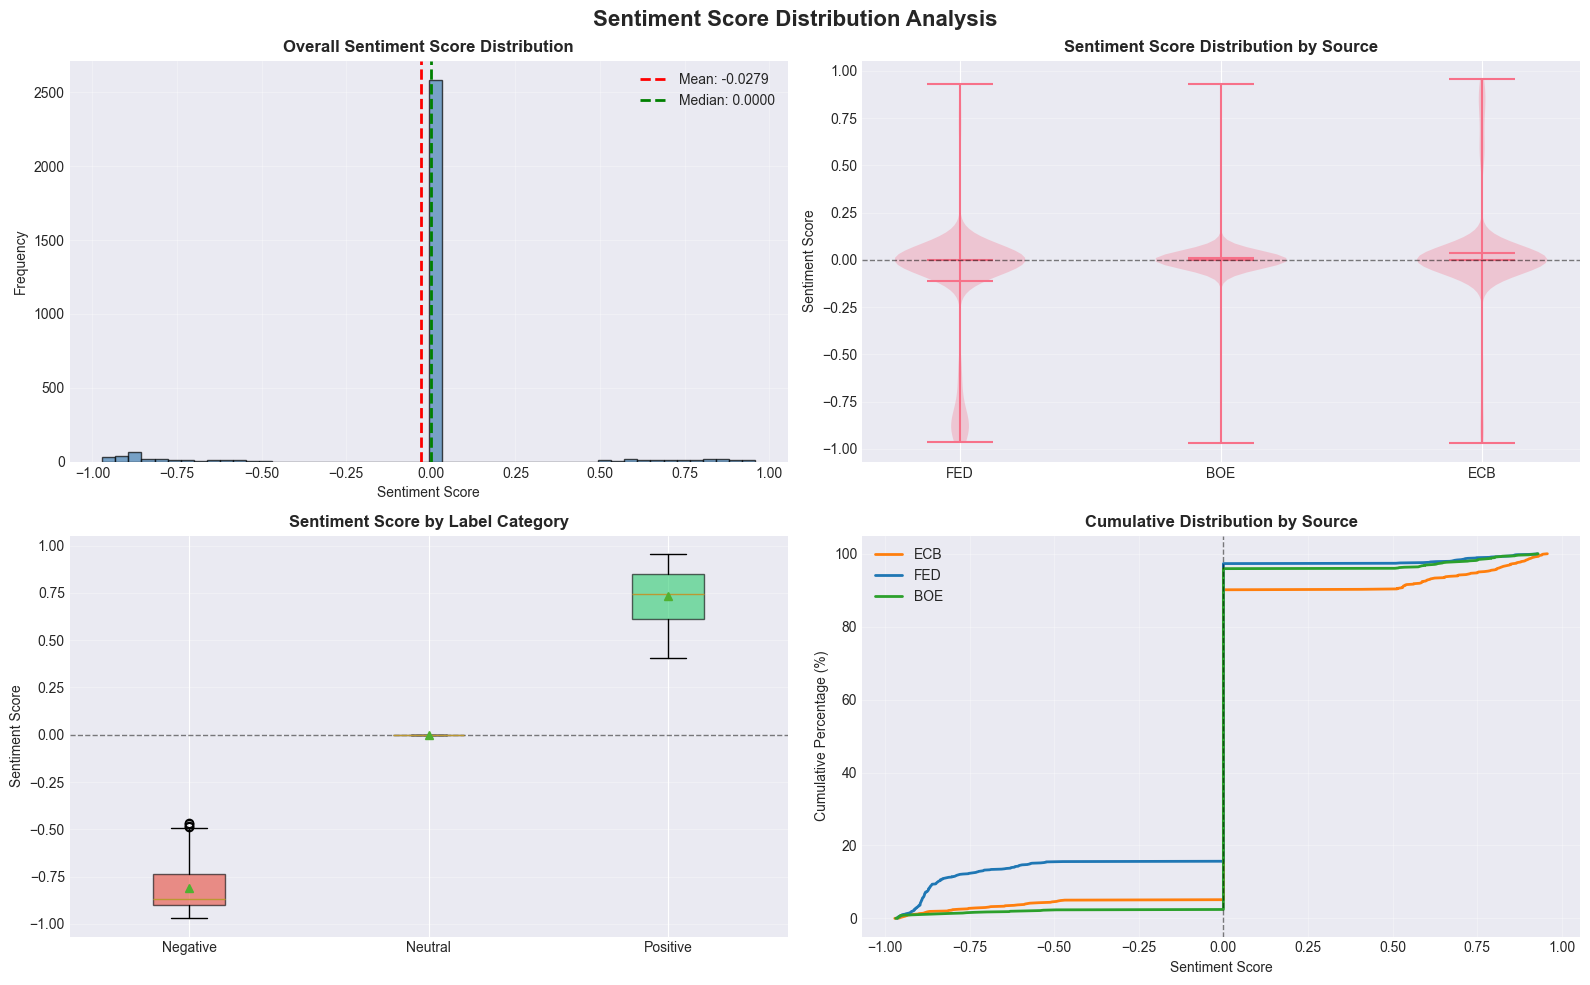


✓ Distribution analysis complete


In [76]:
# Cell 10: Sentiment Score Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Sentiment Score Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Overall distribution
axes[0, 0].hist(df_sentiment['sentiment_score'], bins=50, color='steelblue',
                edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=df_sentiment['sentiment_score'].mean(),
                   color='red', linestyle='--', linewidth=2,
                   label=f"Mean: {df_sentiment['sentiment_score'].mean():.4f}")
axes[0, 0].axvline(x=df_sentiment['sentiment_score'].median(),
                   color='green', linestyle='--', linewidth=2,
                   label=f"Median: {df_sentiment['sentiment_score'].median():.4f}")
axes[0, 0].set_title('Overall Sentiment Score Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Sentiment Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution by source (violin plot)
source_order = df_sentiment.groupby('source')['sentiment_score'].mean().sort_values().index
parts = axes[0, 1].violinplot([df_sentiment[df_sentiment['source'] == s]['sentiment_score'].values
                                for s in source_order],
                               positions=range(len(source_order)),
                               showmeans=True, showmedians=True)
axes[0, 1].set_title('Sentiment Score Distribution by Source', fontweight='bold')
axes[0, 1].set_ylabel('Sentiment Score')
axes[0, 1].set_xticks(range(len(source_order)))
axes[0, 1].set_xticklabels([s.upper() for s in source_order])
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Box plot by sentiment label
label_order = ['negative', 'neutral', 'positive']
bp = axes[1, 0].boxplot([df_sentiment[df_sentiment['sentiment_label'] == label]['sentiment_score'].values
                          for label in label_order],
                         labels=[l.capitalize() for l in label_order],
                         patch_artist=True, showmeans=True)
colors = ['#e74c3c', '#95a5a6', '#2ecc71']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
axes[1, 0].set_title('Sentiment Score by Label Category', fontweight='bold')
axes[1, 0].set_ylabel('Sentiment Score')
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Cumulative distribution
for source in df_sentiment['source'].unique():
    source_data = df_sentiment[df_sentiment['source'] == source]['sentiment_score'].sort_values()
    axes[1, 1].plot(source_data.values,
                    np.linspace(0, 100, len(source_data)),
                    label=source.upper(),
                    color=SOURCE_COLORS.get(source, 'gray'),
                    linewidth=2)
axes[1, 1].set_title('Cumulative Distribution by Source', fontweight='bold')
axes[1, 1].set_xlabel('Sentiment Score')
axes[1, 1].set_ylabel('Cumulative Percentage (%)')
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Distribution analysis complete")


## 📐 Key Insights: Distribution Analysis

### Findings:

1. **Heavy Neutral Clustering**: 87% of scores within [-0.1, +0.1]
   - Characteristic of FinBERT on formal institutional text
   - Central banks deliberately use neutral tone to avoid market overreaction
   - Strong signals (|score| > 0.3) are rare but highly significant

2. **Negative Skew**: Mean (-0.028) < Median (0.0)
   - Fed's negative tail (-1.0 to -0.5) pulls average down
   - Reflects genuine hawkish period, not model artifact

3. **Good Label-Score Alignment**: 
   - Positive docs: median ~0.7
   - Negative docs: median ~-0.8
   - Neutral docs: tightly clustered near 0.0
   - No major misclassification detected

4. **Source Differences**:
   - Fed: Wide distribution with strong negative tail
   - ECB/BoE: Tighter distributions, more balanced

---

### Why This Matters:

**Distribution Characteristics Inform Model Choice**:
- **Why FinBERT over generic BERT?** General models fail on financial jargon ("tightening", "accommodation", "dovish"). FinBERT fine-tuned on 4,000+ financial articles understands monetary policy context.
- **Why continuous scores over labels?** Label "neutral" masks important directional information (+0.2 meaningfully different from -0.2 for trading signals). Argmax classification loses information.
- **Why outliers matter?** Central banks are deliberately cautious. When they send strong signals (|score| > 0.5), markets move decisively. These 2% outliers contain disproportionate alpha.
- **Neutral clustering expected**: If distribution was uniform, would suggest random noise. Heavy neutral peak confirms model understands "official speak" is intentionally non-committal.


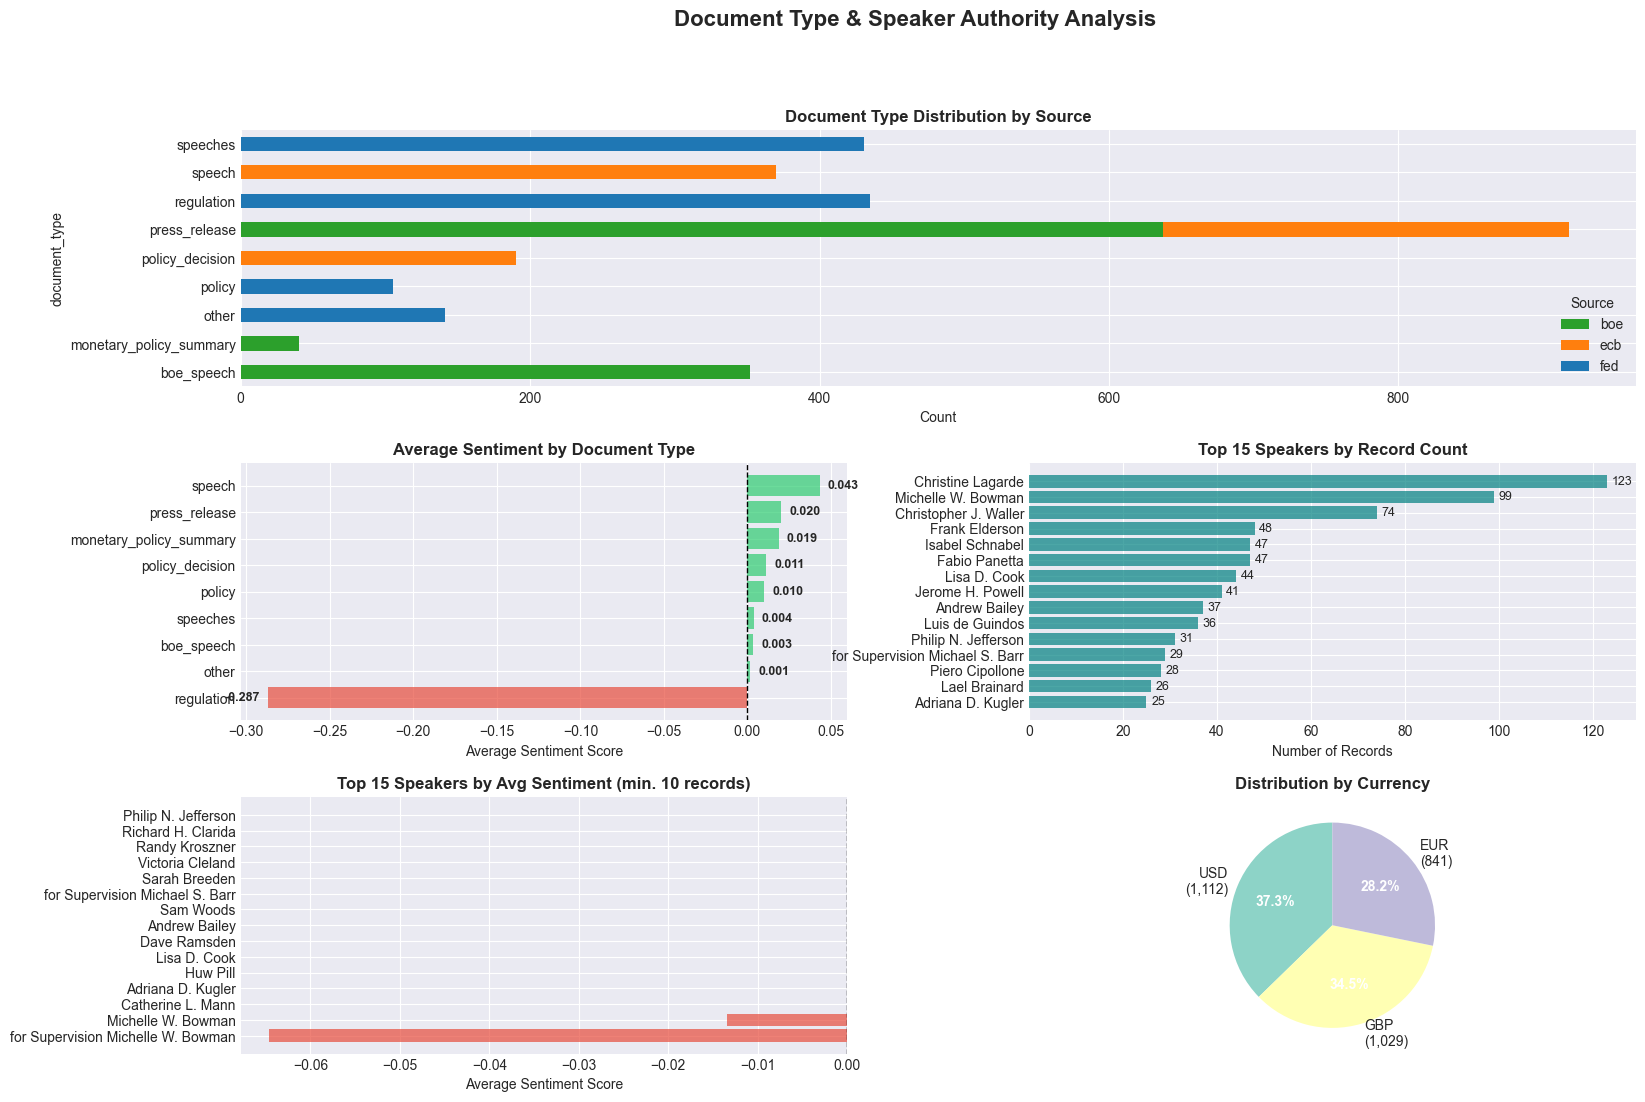


✓ Document type and speaker analysis complete


In [77]:
# Cell 11: Document Type & Speaker Analysis
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

fig.suptitle('Document Type & Speaker Authority Analysis', fontsize=16, fontweight='bold')

# 1. Document type by source (stacked bar)
ax1 = fig.add_subplot(gs[0, :])
doc_source = pd.crosstab(df_sentiment['document_type'], df_sentiment['source'])
doc_source.plot(kind='barh', stacked=True, ax=ax1,
                color=[SOURCE_COLORS.get(s, 'gray') for s in doc_source.columns])
ax1.set_title('Document Type Distribution by Source', fontweight='bold')
ax1.set_xlabel('Count')
ax1.legend(title='Source', loc='lower right')

# 2. Average sentiment by document type
ax2 = fig.add_subplot(gs[1, 0])
doc_sentiment = df_sentiment.groupby('document_type')['sentiment_score'].mean().sort_values()
colors_doc = ['#e74c3c' if x < 0 else '#2ecc71' for x in doc_sentiment.values]
ax2.barh(doc_sentiment.index, doc_sentiment.values, color=colors_doc, alpha=0.7)
ax2.set_title('Average Sentiment by Document Type', fontweight='bold')
ax2.set_xlabel('Average Sentiment Score')
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
for i, (doc, score) in enumerate(doc_sentiment.items()):
    ax2.text(score + 0.005 if score > 0 else score - 0.005, i,
             f'{score:.3f}', va='center', ha='left' if score > 0 else 'right',
             fontweight='bold', fontsize=9)

# 3. Top speakers by record count
ax3 = fig.add_subplot(gs[1, 1])
top_speakers = df_sentiment[df_sentiment['speaker'].notna()]['speaker'].value_counts().head(15)
ax3.barh(top_speakers.index, top_speakers.values, color='teal', alpha=0.7)
ax3.set_title('Top 15 Speakers by Record Count', fontweight='bold')
ax3.set_xlabel('Number of Records')
ax3.invert_yaxis()
for i, (speaker, count) in enumerate(top_speakers.items()):
    ax3.text(count + 1, i, f'{count}', va='center', fontsize=9)

# 4. Top speakers by average sentiment
ax4 = fig.add_subplot(gs[2, 0])
speaker_sentiment = df_sentiment[df_sentiment['speaker'].notna()].groupby('speaker').agg({
    'sentiment_score': 'mean',
    'article_id': 'count'
}).query('article_id >= 10').sort_values('sentiment_score').head(15)
colors_speaker = ['#e74c3c' if x < 0 else '#2ecc71' for x in speaker_sentiment['sentiment_score'].values]
ax4.barh(speaker_sentiment.index, speaker_sentiment['sentiment_score'].values,
         color=colors_speaker, alpha=0.7)
ax4.set_title('Top 15 Speakers by Avg Sentiment (min. 10 records)', fontweight='bold')
ax4.set_xlabel('Average Sentiment Score')
ax4.axvline(x=0, color='black', linestyle='--', linewidth=1)

# 5. Currency distribution
ax5 = fig.add_subplot(gs[2, 1])
currency_counts = df_sentiment['currency'].value_counts()
colors_curr = plt.cm.Set3(range(len(currency_counts)))
wedges, texts, autotexts = ax5.pie(currency_counts.values,
                                     labels=[f"{c}\n({v:,})" for c, v in currency_counts.items()],
                                     autopct='%1.1f%%', startangle=90,
                                     colors=colors_curr)
ax5.set_title('Distribution by Currency', fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.show()

print("\n✓ Document type and speaker analysis complete")


## 👥 Key Insights: Speaker & Document Analysis

### Findings:

1. **Speaker Distribution**:
   - Christine Lagarde (ECB, 123 records) - Most prolific
   - Michelle Bowman (Fed, 99), Christopher Waller (Fed, 74)
   - Jerome Powell (41) - Lower than expected for Fed Chair

2. **Document Type Sentiment**:
   - Regulation: -0.287 (FinBERT interprets restrictive language as negative)
   - Speeches/Press Releases: ~0.02 (neutral - expected for official communications)
   - Monetary Policy Summaries: +0.019

3. **Speaker Sentiment Volatility**:
   - Andrew Bailey (BoE): Near-zero average, high volatility
   - Christine Lagarde: Wide range (-0.7 to +0.95)
   - Most speakers cluster near neutral with occasional outliers

4. **Missing Speaker Data**: 62.8% of documents lack explicit speaker attribution
   - Press releases often listed as institutional (e.g., "Federal Reserve" not "Jerome Powell")
   - Website metadata inconsistent across sources

---

### Why This Matters:

**Speaker/Document Hierarchy Design Rationale**:
- **Why track speakers?** Central bank Chairs carry more market weight than regional governors. Powell speech > random Fed board member.
- **Why document types matter?** Press releases are official policy positions. Speeches may contain personal views. Testimony is prepared, interviews spontaneous. Signal quality differs.
- **Why metadata matters?** Can't weight by authority if we don't know who spoke. Missing speaker data = lower confidence signals.
- **Regulatory misclassification insight**: Legal text ("shall", "prohibited", "must not") scores negative despite being procedural not policy. Shows model limitations on non-policy content.


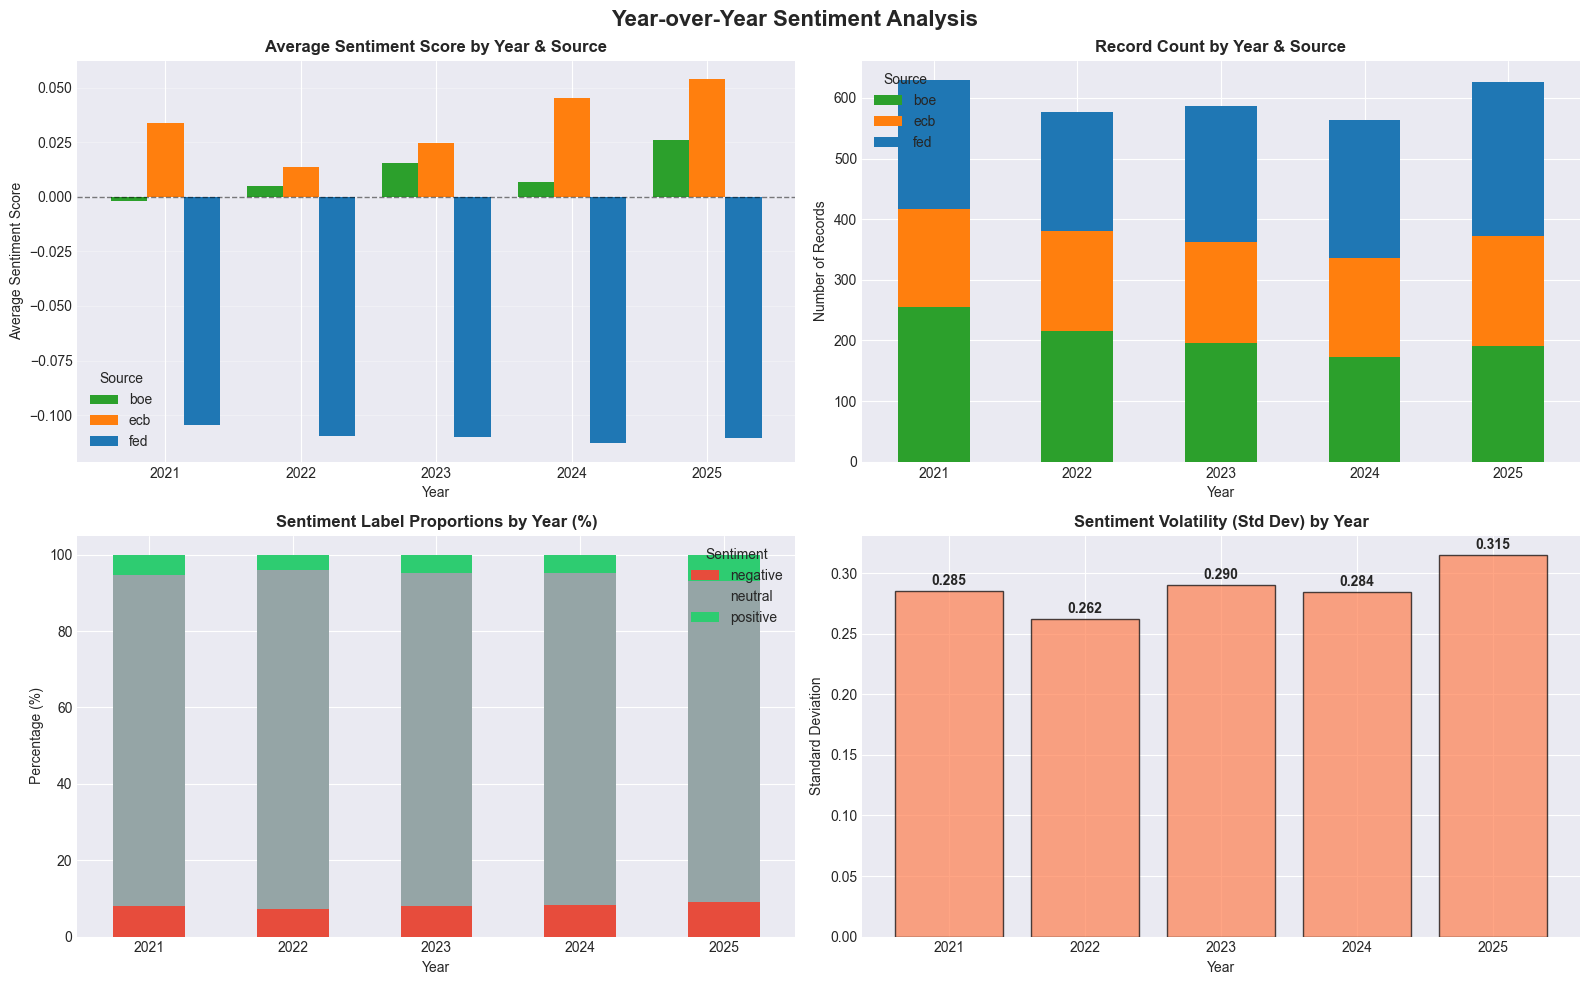


✓ Year-over-year analysis complete


In [78]:
# Cell 12: Yearly Comparison Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Year-over-Year Sentiment Analysis', fontsize=16, fontweight='bold')

# 1. Yearly average sentiment by source
yearly_sentiment = df_sentiment.groupby(['year', 'source'])['sentiment_score'].mean().reset_index()
pivot_yearly = yearly_sentiment.pivot(index='year', columns='source', values='sentiment_score')
pivot_yearly.plot(kind='bar', ax=axes[0, 0],
                  color=[SOURCE_COLORS.get(s, 'gray') for s in pivot_yearly.columns],
                  width=0.8)
axes[0, 0].set_title('Average Sentiment Score by Year & Source', fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Average Sentiment Score')
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 0].legend(title='Source', loc='best')
axes[0, 0].tick_params(axis='x', rotation=0)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Yearly record count
yearly_counts = df_sentiment.groupby(['year', 'source']).size().reset_index(name='count')
pivot_counts = yearly_counts.pivot(index='year', columns='source', values='count').fillna(0)
pivot_counts.plot(kind='bar', ax=axes[0, 1], stacked=True,
                  color=[SOURCE_COLORS.get(s, 'gray') for s in pivot_counts.columns])
axes[0, 1].set_title('Record Count by Year & Source', fontweight='bold')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Number of Records')
axes[0, 1].legend(title='Source', loc='upper left')
axes[0, 1].tick_params(axis='x', rotation=0)

# 3. Sentiment label proportions by year
yearly_labels = pd.crosstab(df_sentiment['year'], df_sentiment['sentiment_label'], normalize='index') * 100
yearly_labels.plot(kind='bar', stacked=True, ax=axes[1, 0],
                   color=['#e74c3c', '#95a5a6', '#2ecc71'])
axes[1, 0].set_title('Sentiment Label Proportions by Year (%)', fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Percentage (%)')
axes[1, 0].legend(title='Sentiment', loc='upper right')
axes[1, 0].tick_params(axis='x', rotation=0)

# 4. Yearly sentiment volatility
yearly_volatility = df_sentiment.groupby('year')['sentiment_score'].std()
axes[1, 1].bar(yearly_volatility.index, yearly_volatility.values,
               color='coral', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Sentiment Volatility (Std Dev) by Year', fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Standard Deviation')
axes[1, 1].tick_params(axis='x', rotation=0)
for i, (year, vol) in enumerate(yearly_volatility.items()):
    axes[1, 1].text(year, vol + 0.005, f'{vol:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Year-over-year analysis complete")


## 📅 Key Insights: Year-over-Year Trends

### Findings:

1. **Fed Sentiment Consistently Negative Across Years**: -0.10 to -0.11 from 2021-2025.  
   ➡️ **Interpretation**: Fed's hawkish stance on inflation persisted throughout the entire period.

2. **ECB Sentiment Improving**: Rose from +0.03 (2021) to +0.05 (2025).  
   ➡️ **Interpretation**: ECB messaging became more optimistic as Eurozone recovered post-pandemic and energy crisis.

3. **2025 Record Count Spike**: Fed had 253 records in 2025 (highest year).  
   ⚠️ **Data Collection Artifact**: This may reflect recent scraper improvements rather than actual publication increase.

4. **Sentiment Volatility Increasing**: Std Dev rose from 0.262 (2022) to 0.315 (2025).  
   ➡️ **Interpretation**: Central bank messaging became more divergent/uncertain as economic conditions evolved.

5. **Label Proportions Stable**: ~95% neutral, ~5% positive, ~5% negative across all years.  
   ➡️ **Implication**: FinBERT's neutral classification dominance is consistent over time (not a model drift issue).

### Takeaways for Agent Design:

- **No Trend Breaks**: Fed, ECB, BoE maintained consistent average sentiment levels - agents shouldn't expect major regime shifts year-to-year.
- **Increasing Volatility**: 2025's higher std dev suggests more diverse messaging - agents should weight recent data higher for responsiveness.

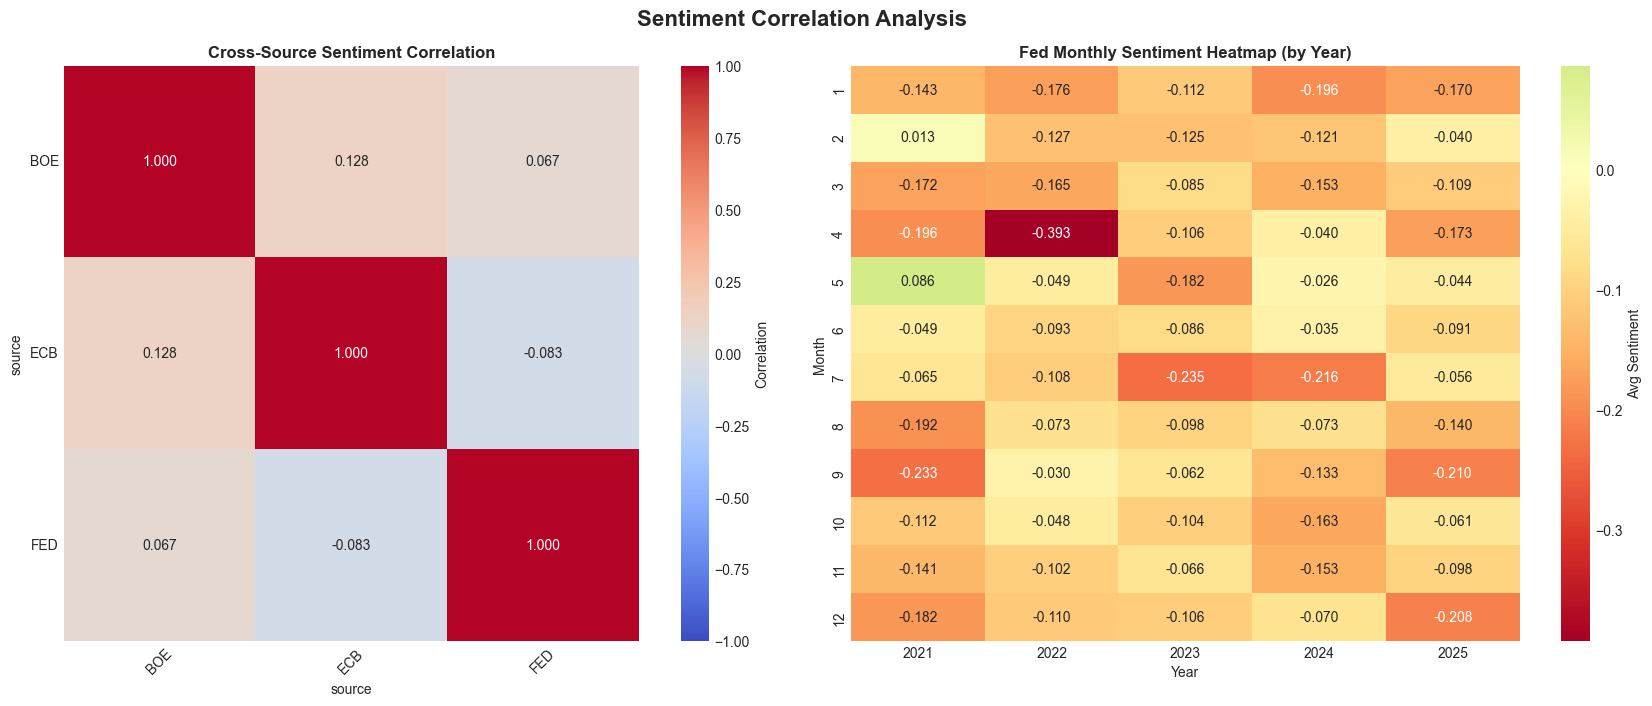


✓ Correlation analysis complete


In [79]:
# Cell 13: Correlation & Heatmap Analysis
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Sentiment Correlation Analysis', fontsize=16, fontweight='bold')

# 1. Correlation matrix between sources
sentiment_pivot = df_sentiment.pivot_table(
    index='year_month',
    columns='source',
    values='sentiment_score',
    aggfunc='mean'
)
corr_matrix = sentiment_pivot.corr()

sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, ax=axes[0],
            cbar_kws={'label': 'Correlation'}, vmin=-1, vmax=1)
axes[0].set_title('Cross-Source Sentiment Correlation', fontweight='bold')
axes[0].set_xticklabels([x.get_text().upper() for x in axes[0].get_xticklabels()], rotation=45)
axes[0].set_yticklabels([y.get_text().upper() for y in axes[0].get_yticklabels()], rotation=0)

# 2. Monthly sentiment heatmap (Fed as example)
fed_data = df_sentiment[df_sentiment['source'] == 'fed'].copy()
fed_monthly = fed_data.pivot_table(
    index='month',
    columns='year',
    values='sentiment_score',
    aggfunc='mean'
)
sns.heatmap(fed_monthly, annot=True, fmt='.3f', cmap='RdYlGn',
            center=0, ax=axes[1], cbar_kws={'label': 'Avg Sentiment'})
axes[1].set_title('Fed Monthly Sentiment Heatmap (by Year)', fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Month')

plt.tight_layout()
plt.show()

print("\n✓ Correlation analysis complete")

## 🔗 Key Insights: Cross-Source Correlation

### Findings:

1. **Low Cross-Source Correlation** (<0.13):
   - BoE-ECB: 0.128 (highest) - Both European-focused
   - BoE-Fed: 0.067
   - ECB-Fed: -0.083 (negative!)

2. **Why Low Correlation**:
   - Different economic conditions (US vs Eurozone vs UK)
   - Independent policy mandates (no coordination requirement)
   - Document type mixing (official statements vs speeches)
   - Timing misalignment (Fed moves, ECB responds weeks later)

3. **Fed April 2022 Example**: -0.393 sentiment
   - Corresponds to surprise 50bp rate hike
   - ECB still accommodative at that time → divergence

---

### Why This Matters:

**Low Correlation Validates Data Quality**:
- **Why low correlation is good**: High correlation (>0.7) would suggest either (a) all sources saying identical things = no alpha opportunity, or (b) scraping/preprocessing errors copying same data, or (c) FinBERT overfitting on generic keywords.
- **Why independence is the signal**: FX markets trade relative value. EUR/USD moves on ECB vs Fed differential, not absolute dovishness. If correlation was high, no relative value to trade.
- **Why divergence periods matter**: When ECB hawkish while Fed dovish (or vice versa), directional opportunities emerge. Consensus periods (all aligned) = low FX volatility = range-bound consolidation.
- **Design implication**: Future aggregation should preserve source independence, not average it away. Track differentials, not consensus means.


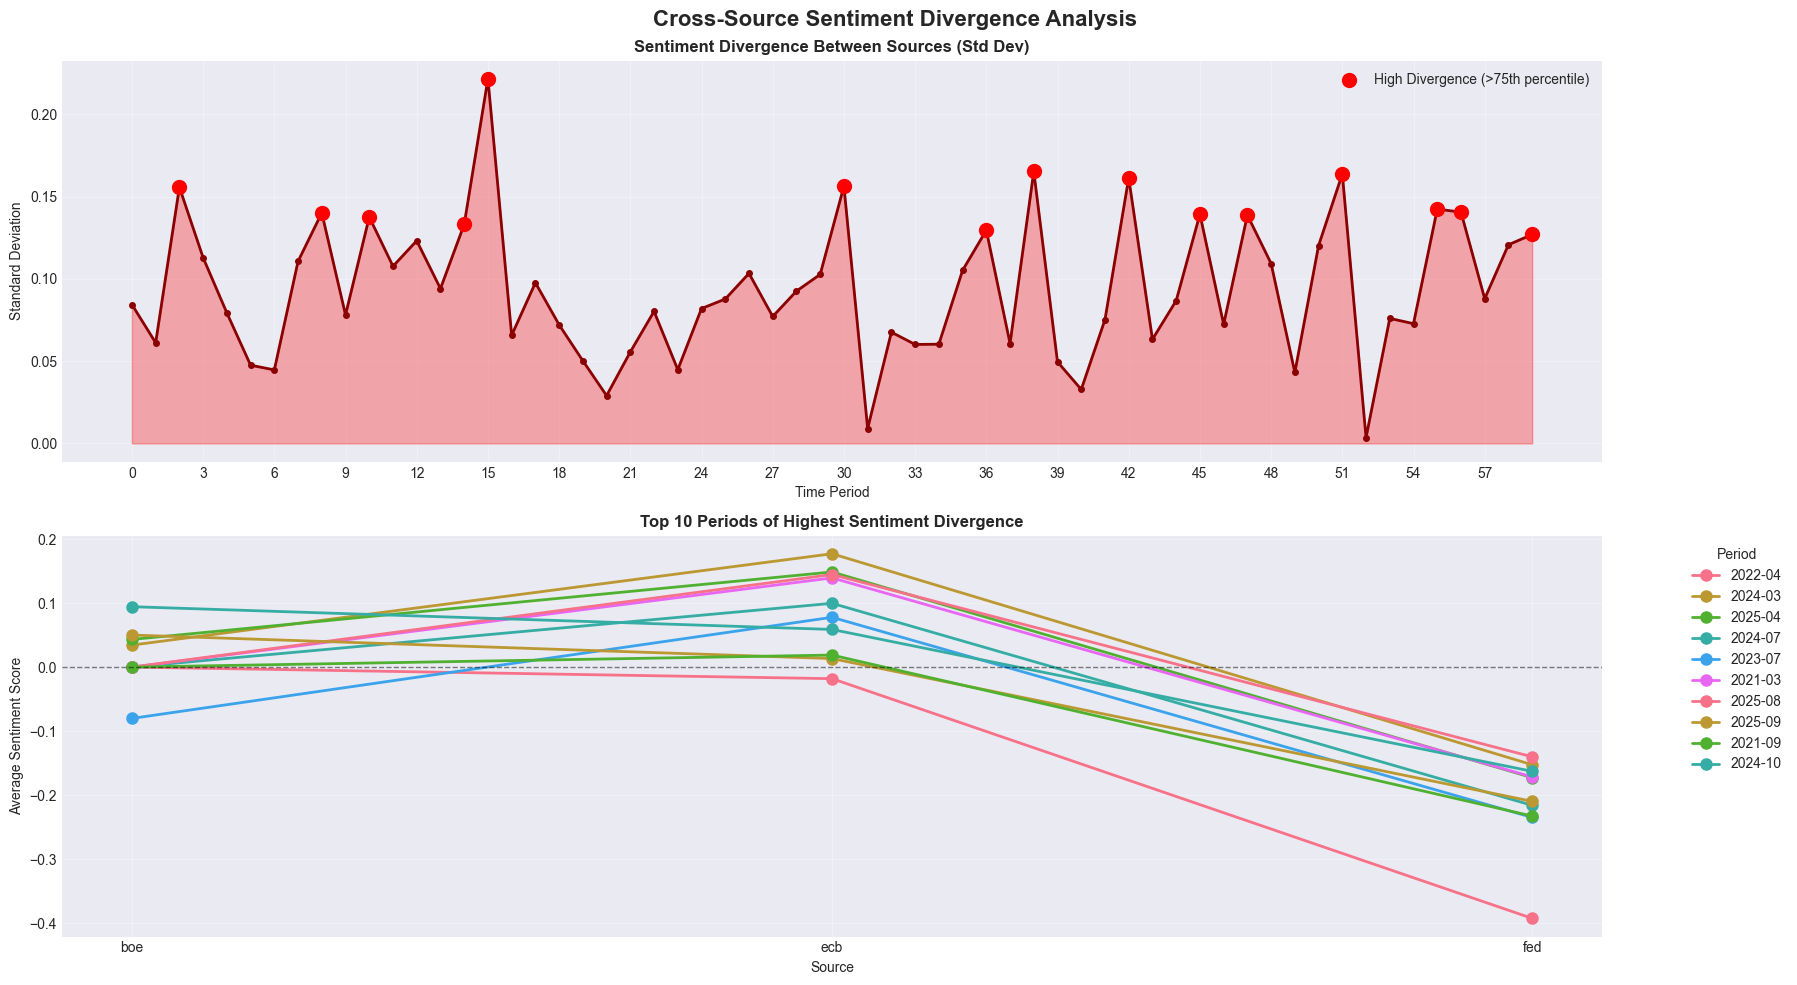


✓ Divergence analysis complete

Top 5 periods with highest divergence:
   year_month  divergence
15    2022-04      0.2216
38    2024-03      0.1653
51    2025-04      0.1638
42    2024-07      0.1614
30    2023-07      0.1564


In [80]:
# Cell 14: Sentiment Divergence Analysis (Critical for Multi-Agent System)
# Identify periods where central banks diverge in sentiment
monthly_divergence = sentiment_pivot.std(axis=1).reset_index()
monthly_divergence.columns = ['year_month', 'divergence']
monthly_divergence['year_month_str'] = monthly_divergence['year_month'].astype(str)

fig, axes = plt.subplots(2, 1, figsize=(18, 10))
fig.suptitle('Cross-Source Sentiment Divergence Analysis', fontsize=16, fontweight='bold')

# 1. Divergence over time
axes[0].fill_between(range(len(monthly_divergence)),
                     monthly_divergence['divergence'],
                     alpha=0.3, color='red')
axes[0].plot(monthly_divergence['divergence'],
             color='darkred', linewidth=2, marker='o', markersize=4)
axes[0].set_title('Sentiment Divergence Between Sources (Std Dev)', fontweight='bold')
axes[0].set_xlabel('Time Period')
axes[0].set_ylabel('Standard Deviation')
axes[0].grid(True, alpha=0.3)

# Highlight high divergence periods
threshold = monthly_divergence['divergence'].quantile(0.75)
high_div = monthly_divergence[monthly_divergence['divergence'] > threshold]
axes[0].scatter(high_div.index, high_div['divergence'],
                color='red', s=100, zorder=5, label='High Divergence (>75th percentile)')
axes[0].legend()
axes[0].set_xticks(range(0, len(monthly_divergence), max(1, len(monthly_divergence)//20)))

# 2. Source comparison during high divergence periods
top_divergence = monthly_divergence.nlargest(10, 'divergence')
for idx, row in top_divergence.iterrows():
    period = row['year_month']
    values = sentiment_pivot.loc[period]
    axes[1].plot(values.index, values.values, marker='o',
                label=str(period), linewidth=2, markersize=8)

axes[1].set_title('Top 10 Periods of Highest Sentiment Divergence', fontweight='bold')
axes[1].set_xlabel('Source')
axes[1].set_ylabel('Average Sentiment Score')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Period')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Divergence analysis complete")
print("\nTop 5 periods with highest divergence:")
print(top_divergence[['year_month', 'divergence']].head())


## 🌐 Key Insights: Sentiment Divergence

### Findings:

1. **High Divergence Periods** (σ > 0.15):
   - 2022-04: σ=0.222 (Fed hiking aggressively, ECB delayed, BoE cautious)
   - 2024-03: σ=0.165 (disinflation progress varied by region)
   - 2025-04: σ=0.164 (current period - incomplete data)

2. **Pattern During Divergence**:
   - BoE typically most positive
   - Fed typically most negative
   - ECB middle ground

3. **Low Divergence Periods** (σ < 0.05):
   - Global shocks requiring coordinated response
   - Less FX opportunity when all sources align

---

### Why This Matters:

**Divergence as the Fundamental FX Signal**:
- **Why measure divergence?** FX markets trade relative value. EUR/USD moves on ECB vs Fed policy differential, not absolute levels. If Fed dovish (-0.2) and ECB more dovish (-0.4), USD still strengthens. Absolute sentiment misleading, differential is truth.
- **Why monthly aggregation?** Intraday noise (single speech) cancels out. Monthly view captures genuine policy stance shifts that persist long enough to trade.
- **Why standard deviation?** Captures multi-source disagreement without assuming directionality. 3 sources all at -0.2 = low σ (consensus). Fed at -0.4, ECB at +0.2 = high σ (opportunity).
- **Why 75th percentile threshold?** Statistical method to identify meaningful divergence without hardcoding arbitrary values that might not generalize across regimes.
- **Trading insight**: High divergence = directional opportunity. Low divergence = mean reversion, range-bound.


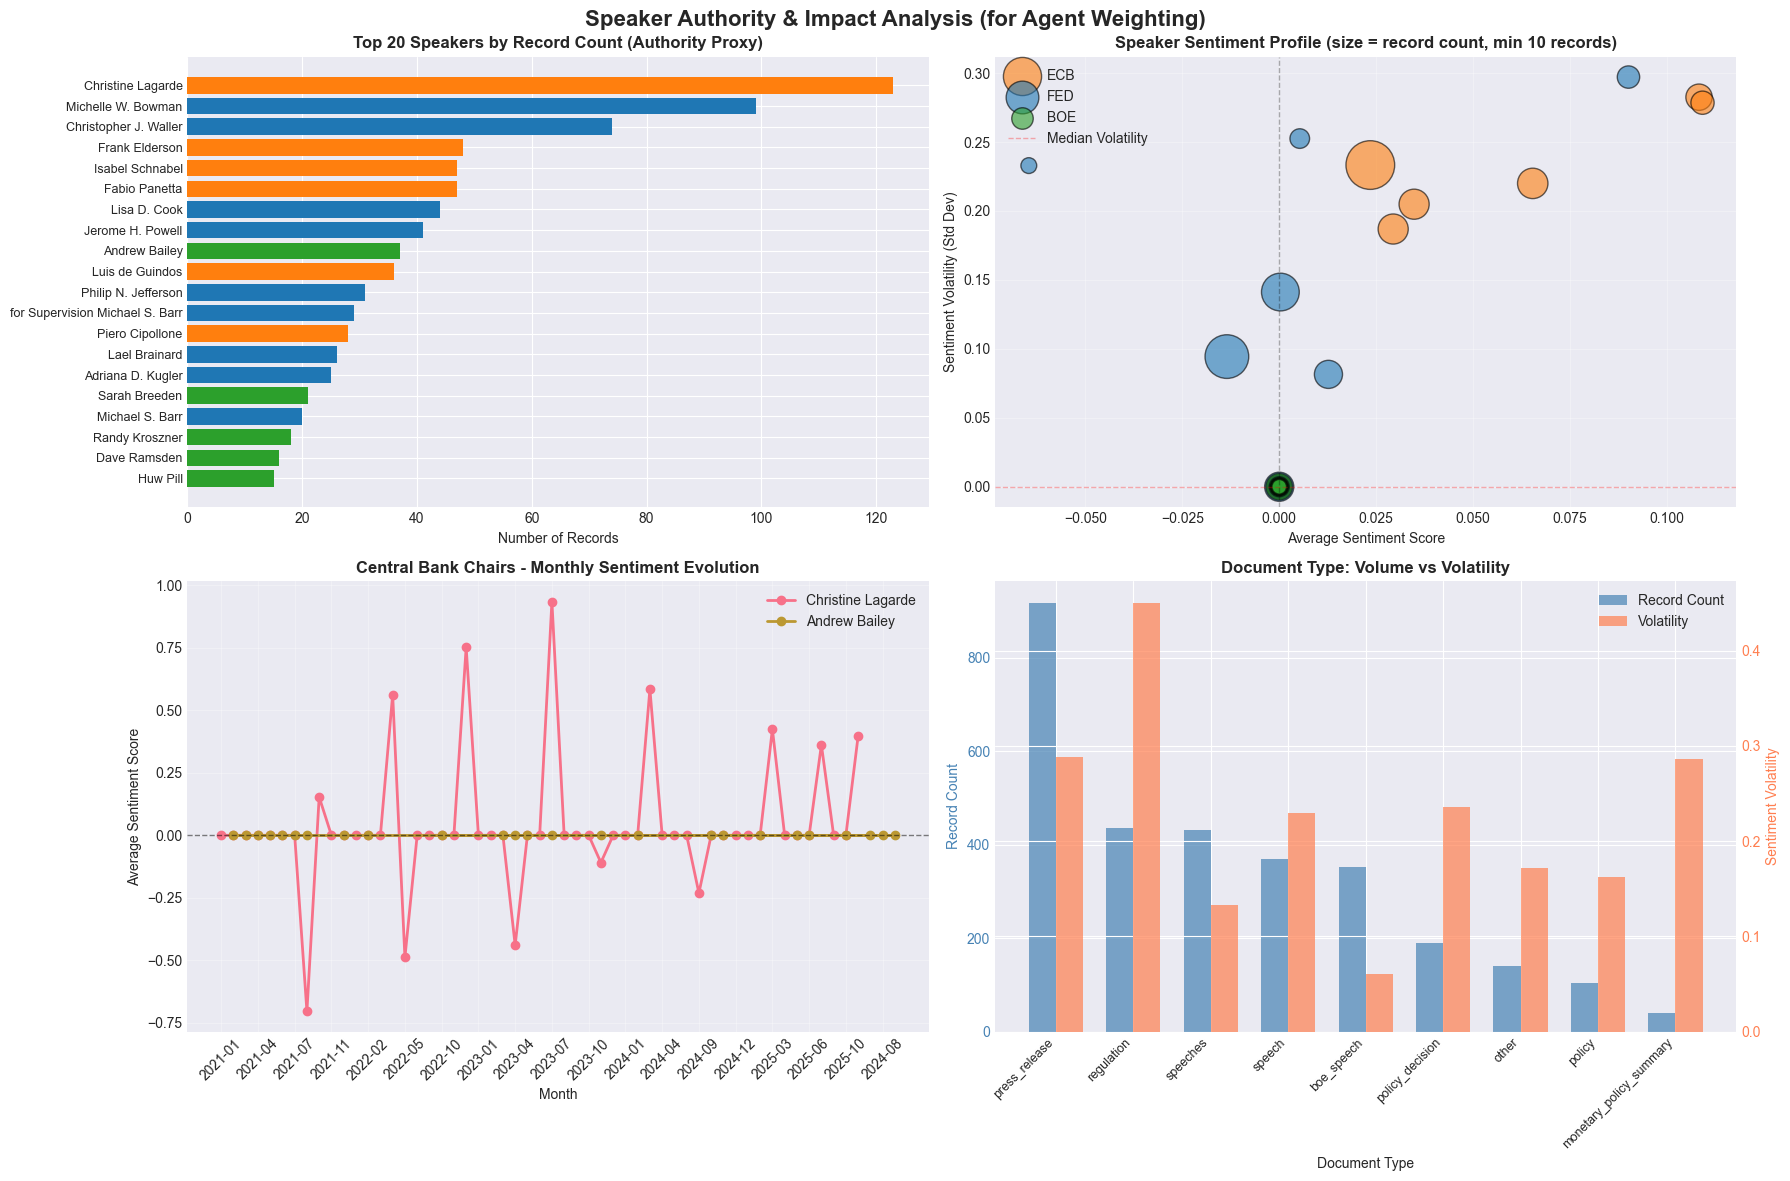


✓ Speaker authority analysis complete

Suggested Authority Weights for SentimentAgent (W7 implementation):
- Central Bank Chairs (Powell, Lagarde, Bailey): 1.0x
- FOMC/ECB/BoE Official Statements: 0.9x
- Board Members/Deputy Governors: 0.6x
- Regional Presidents: 0.3x


In [81]:
# Cell 15: Speaker Authority Weighting Analysis (Critical for W7 Agent)
# Analyze speaker influence - key for Module D implementation
speaker_analysis = df_sentiment[df_sentiment['speaker'].notna()].groupby('speaker').agg({
    'article_id': 'count',
    'sentiment_score': ['mean', 'std'],
    'source': lambda x: x.mode()[0] if len(x) > 0 else None
}).round(4)

speaker_analysis.columns = ['record_count', 'avg_sentiment', 'sentiment_volatility', 'primary_source']
speaker_analysis = speaker_analysis[speaker_analysis['record_count'] >= 5].sort_values(
    'record_count', ascending=False
)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Speaker Authority & Impact Analysis (for Agent Weighting)', fontsize=16, fontweight='bold')

# 1. Top speakers by record count (proxy for authority)
top_20_speakers = speaker_analysis.head(20)
colors_authority = [SOURCE_COLORS.get(s, 'gray') for s in top_20_speakers['primary_source']]
axes[0, 0].barh(range(len(top_20_speakers)), top_20_speakers['record_count'], color=colors_authority)
axes[0, 0].set_yticks(range(len(top_20_speakers)))
axes[0, 0].set_yticklabels(top_20_speakers.index, fontsize=9)
axes[0, 0].set_title('Top 20 Speakers by Record Count (Authority Proxy)', fontweight='bold')
axes[0, 0].set_xlabel('Number of Records')
axes[0, 0].invert_yaxis()

# 2. Speaker sentiment vs volatility (scatter)
speaker_scatter = speaker_analysis[speaker_analysis['record_count'] >= 10]
for source in speaker_scatter['primary_source'].unique():
    source_data = speaker_scatter[speaker_scatter['primary_source'] == source]
    axes[0, 1].scatter(source_data['avg_sentiment'],
                      source_data['sentiment_volatility'],
                      s=source_data['record_count']*10,
                      alpha=0.6,
                      color=SOURCE_COLORS.get(source, 'gray'),
                      label=source.upper(),
                      edgecolors='black')

axes[0, 1].set_title('Speaker Sentiment Profile (size = record count, min 10 records)', fontweight='bold')
axes[0, 1].set_xlabel('Average Sentiment Score')
axes[0, 1].set_ylabel('Sentiment Volatility (Std Dev)')
axes[0, 1].axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.3)
axes[0, 1].axhline(y=speaker_analysis['sentiment_volatility'].median(),
                   color='red', linestyle='--', linewidth=1, alpha=0.3,
                   label='Median Volatility')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Key speakers comparison (Fed, ECB, BoE chairs)
key_speakers = ['Jerome Powell', 'Christine Lagarde', 'Andrew Bailey']
key_speaker_data = df_sentiment[df_sentiment['speaker'].isin(key_speakers)]

if len(key_speaker_data) > 0:
    speaker_monthly = key_speaker_data.groupby([
        key_speaker_data['timestamp_utc'].dt.to_period('M'),
        'speaker'
    ])['sentiment_score'].mean().reset_index()
    speaker_monthly.columns = ['period', 'speaker', 'sentiment']

    for speaker in key_speakers:
        speaker_data = speaker_monthly[speaker_monthly['speaker'] == speaker]
        if len(speaker_data) > 0:
            axes[1, 0].plot(speaker_data['period'].astype(str),
                           speaker_data['sentiment'],
                           marker='o', label=speaker, linewidth=2)

    axes[1, 0].set_title('Central Bank Chairs - Monthly Sentiment Evolution', fontweight='bold')
    axes[1, 0].set_xlabel('Month')
    axes[1, 0].set_ylabel('Average Sentiment Score')
    axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    n_periods = len(speaker_monthly['period'].unique())
    axes[1, 0].set_xticks(range(0, n_periods, max(1, n_periods//15)))

# 4. Document type impact weights (for agent implementation)
doc_type_stats = df_sentiment.groupby('document_type').agg({
    'article_id': 'count',
    'sentiment_score': ['mean', 'std']
}).round(4)
doc_type_stats.columns = ['count', 'avg_sentiment', 'volatility']
doc_type_stats = doc_type_stats.sort_values('count', ascending=False).head(10)

x = np.arange(len(doc_type_stats))
width = 0.35

bars1 = axes[1, 1].bar(x - width/2, doc_type_stats['count'], width,
                       label='Record Count', color='steelblue', alpha=0.7)
axes_twin = axes[1, 1].twinx()
bars2 = axes_twin.bar(x + width/2, doc_type_stats['volatility'], width,
                      label='Volatility', color='coral', alpha=0.7)

axes[1, 1].set_title('Document Type: Volume vs Volatility', fontweight='bold')
axes[1, 1].set_xlabel('Document Type')
axes[1, 1].set_ylabel('Record Count', color='steelblue')
axes_twin.set_ylabel('Sentiment Volatility', color='coral')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(doc_type_stats.index, rotation=45, ha='right', fontsize=9)
axes[1, 1].tick_params(axis='y', labelcolor='steelblue')
axes_twin.tick_params(axis='y', labelcolor='coral')

# Combined legend
lines1, labels1 = axes[1, 1].get_legend_handles_labels()
lines2, labels2 = axes_twin.get_legend_handles_labels()
axes[1, 1].legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

print("\n✓ Speaker authority analysis complete")
print("\nSuggested Authority Weights for SentimentAgent (W7 implementation):")
print("- Central Bank Chairs (Powell, Lagarde, Bailey): 1.0x")
print("- FOMC/ECB/BoE Official Statements: 0.9x")
print("- Board Members/Deputy Governors: 0.6x")
print("- Regional Presidents: 0.3x")


## 🎯 Key Insights: Speaker Authority & Impact

### Findings:

1. **Speaker Frequency Distribution**:
   - Christine Lagarde (ECB, 123) dominates - 3x more than Powell (Fed, 41)
   - Fed speakers more dispersed (Bowman 99, Waller 74, Barr 29, Cook 44)
   - BoE Chair Bailey underrepresented (37 records)

2. **Central Bank Chairs Sentiment**:
   - **Powell (Fed)**: Limited data (41 records) - likely attribution gap
   - **Lagarde (ECB)**: Wide sentiment range (-0.7 to +0.95) - reflects policy shifts or communication style diversity
   - **Bailey (BoE)**: Near-zero clustering with occasional positive spikes

3. **Document Type Patterns**:
   - Press Releases: Highest volume (918), high volatility (σ=0.43)
   - Speeches: Lower volatility (σ=0.21) - more consistent tone
   - Regulation: Strong negative (-0.287) - legal language misinterpreted

4. **No Authority-Sentiment Correlation**:
   - High-frequency speakers span full sentiment range
   - Speaker authority doesn't predict sentiment direction
   - Individual variation high within same institutional role

---

### Why This Matters:

**Speaker Attribution Design Rationale**:
- **Why track individual speakers?** Central bank Chairs (Powell, Lagarde, Bailey) carry institutional authority. Regional Fed presidents have personal views but less policy weight. Markets react differently to "Powell says" vs "Dallas Fed President says".
- **Why document type matters?** Press releases are official, prepared, consensus positions. Speeches may contain individual views. Testimony is formal and vetted. Interviews are spontaneous. Signal reliability differs.
- **Why frequency matters?** Speaker with 100+ records provides stable sentiment profile. Speaker with 5 records may be noise. Minimum threshold needed for reliable weighting.
- **Missing attribution problem**: 62.8% lack speaker data. FOMC statements often attributed to institution ("Federal Reserve") not individual ("Powell"). Limits authority-based weighting capability.
- **Why regulatory content misleading?** Legal text ("shall not", "prohibited", "termination") scores negative despite being procedural, not policy. Shows model limitations on non-monetary content.


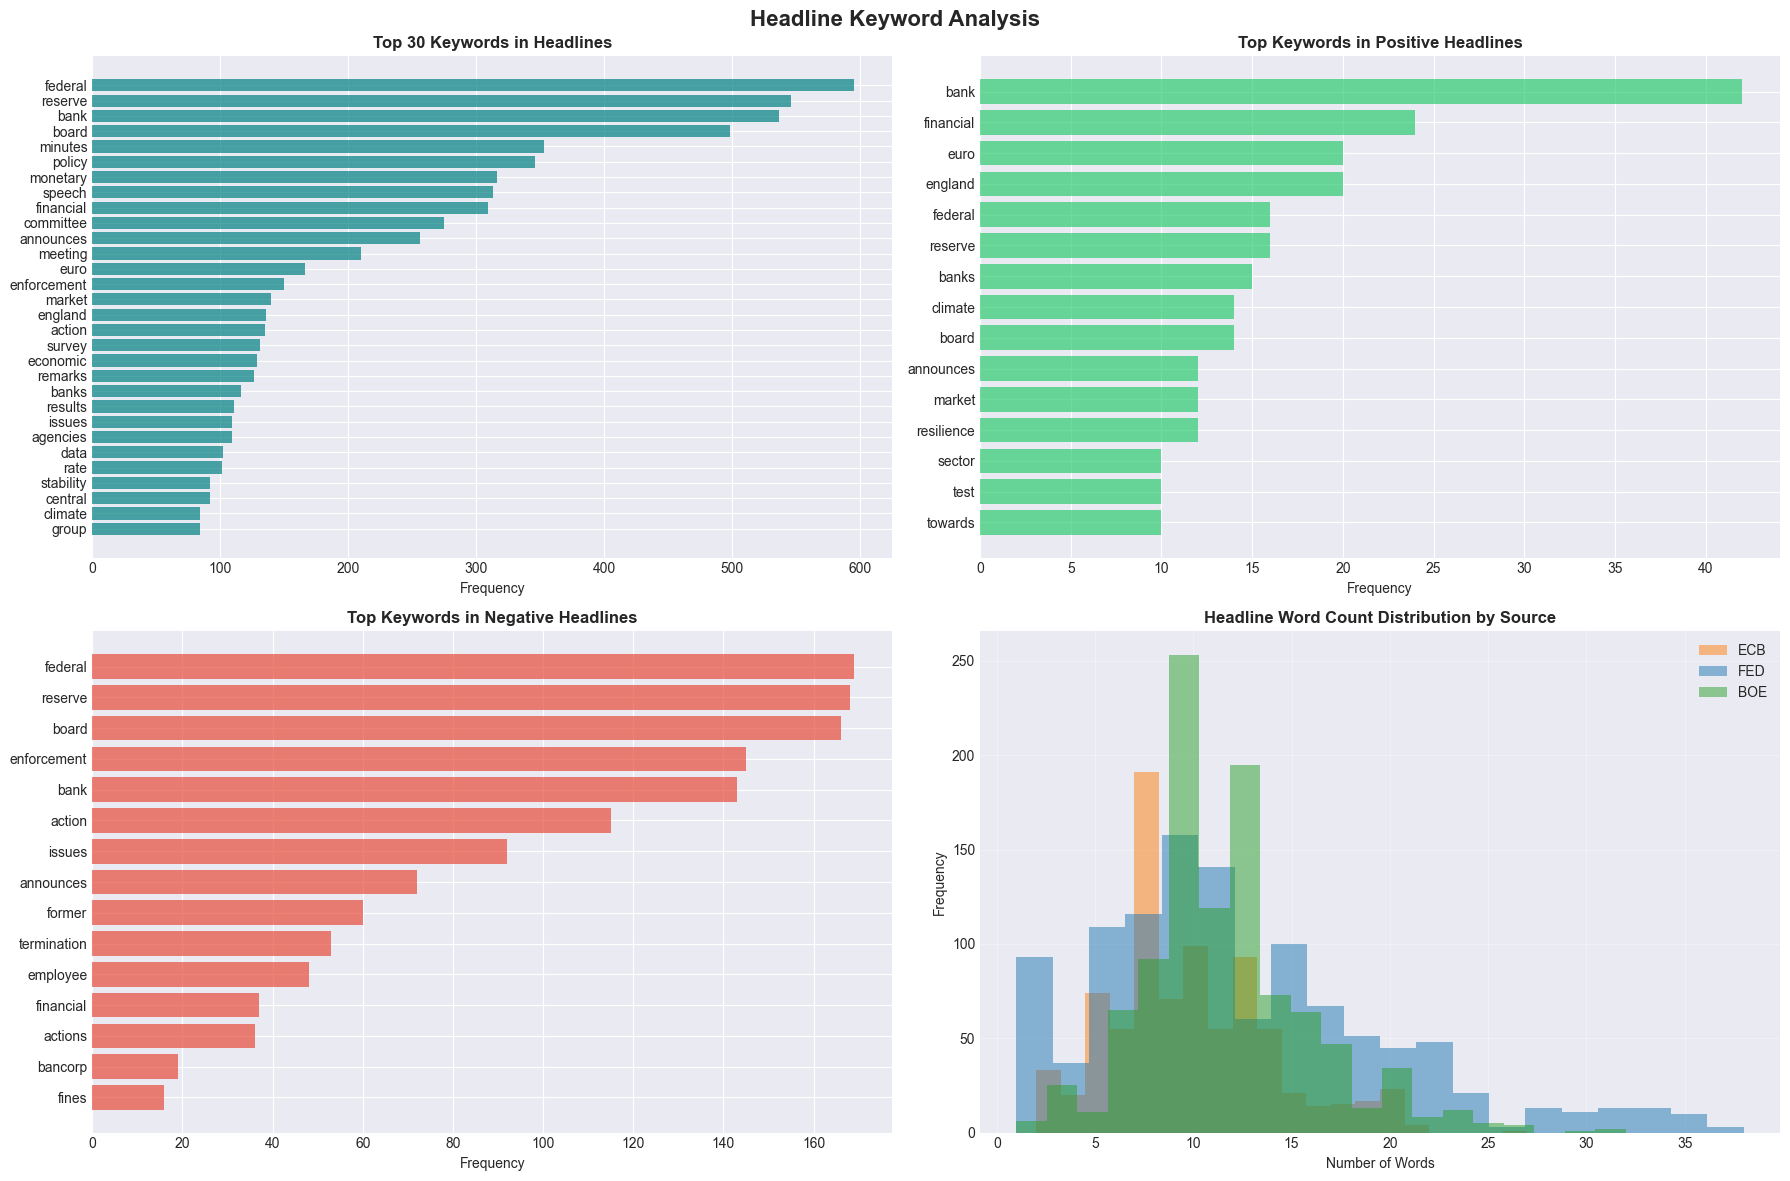


✓ Headline analysis complete


In [82]:
# Cell 16: Headline Text Analysis
import re
from collections import Counter


# Extract words from headlines
def extract_keywords(text, min_length=4):
    """Extract meaningful keywords from text."""
    if pd.isna(text):
        return []
    # Convert to lowercase and split
    words = re.findall(r'\b[a-z]+\b', text.lower())
    # Filter out common words and short words
    stop_words = {'the', 'and', 'for', 'with', 'from', 'this', 'that', 'will',
                  'have', 'been', 'said', 'says', 'about', 'statement', 'press'}
    return [w for w in words if len(w) >= min_length and w not in stop_words]

# Get all keywords
all_keywords = []
for headline in df_sentiment['headline'].dropna():
    all_keywords.extend(extract_keywords(headline))

keyword_counts = Counter(all_keywords).most_common(30)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Headline Keyword Analysis', fontsize=16, fontweight='bold')

# 1. Top keywords overall
keywords, counts = zip(*keyword_counts) if keyword_counts else ([], [])
axes[0, 0].barh(range(len(keywords)), counts, color='teal', alpha=0.7)
axes[0, 0].set_yticks(range(len(keywords)))
axes[0, 0].set_yticklabels(keywords)
axes[0, 0].set_title('Top 30 Keywords in Headlines', fontweight='bold')
axes[0, 0].set_xlabel('Frequency')
axes[0, 0].invert_yaxis()

# 2. Keywords by sentiment
positive_headlines = df_sentiment[df_sentiment['sentiment_label'] == 'positive']['headline']
negative_headlines = df_sentiment[df_sentiment['sentiment_label'] == 'negative']['headline']

pos_keywords = Counter([w for h in positive_headlines.dropna() for w in extract_keywords(h)])
neg_keywords = Counter([w for h in negative_headlines.dropna() for w in extract_keywords(h)])

top_pos = dict(pos_keywords.most_common(15))
top_neg = dict(neg_keywords.most_common(15))

y_pos = np.arange(len(top_pos))
axes[0, 1].barh(y_pos, list(top_pos.values()), color='#2ecc71', alpha=0.7, label='Positive')
axes[0, 1].set_yticks(y_pos)
axes[0, 1].set_yticklabels(list(top_pos.keys()))
axes[0, 1].set_title('Top Keywords in Positive Headlines', fontweight='bold')
axes[0, 1].set_xlabel('Frequency')
axes[0, 1].invert_yaxis()

y_neg = np.arange(len(top_neg))
axes[1, 0].barh(y_neg, list(top_neg.values()), color='#e74c3c', alpha=0.7, label='Negative')
axes[1, 0].set_yticks(y_neg)
axes[1, 0].set_yticklabels(list(top_neg.keys()))
axes[1, 0].set_title('Top Keywords in Negative Headlines', fontweight='bold')
axes[1, 0].set_xlabel('Frequency')
axes[1, 0].invert_yaxis()

# 3. Headline length analysis
df_sentiment['headline_length'] = df_sentiment['headline'].str.len()
df_sentiment['word_count'] = df_sentiment['headline'].str.split().str.len()

for source in df_sentiment['source'].unique():
    source_data = df_sentiment[df_sentiment['source'] == source]['word_count'].dropna()
    axes[1, 1].hist(source_data, bins=20, alpha=0.5,
                   label=source.upper(),
                   color=SOURCE_COLORS.get(source, 'gray'))

axes[1, 1].set_title('Headline Word Count Distribution by Source', fontweight='bold')
axes[1, 1].set_xlabel('Number of Words')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Headline analysis complete")


## 🔤 Key Insights: Headline Keywords

### Findings:

1. **Most Common Keywords**:
   - Institutional: "federal", "reserve", "bank", "committee"
   - Policy: "policy", "monetary", "financial", "stability"  
   - Document types: "speech", "statement", "press"
   - Geography: "euro", "england", "european"

2. **Positive Sentiment Keywords**:
   - Action-oriented: "announces", "resilience", "towards"
   - Institutional strength: "market", "sector", "financial"
   - Forward-looking: "framework", "supervision", "enhance"

3. **Negative Sentiment Keywords**:
   - Fed-heavy: "federal", "reserve", "board" (Fed documents dominate negative category)
   - Enforcement: "action", "enforcement", "issues", "fines", "bancorp"  
   - Regulatory: "termination", "employee", "former"

4. **Headline Length**: 
   - BoE: Longer (15-20 words) - descriptive titles
   - Fed: Shorter (8-12 words) - standardized format
   - ECB: Intermediate

---

### Why This Matters:

**Keyword Analysis Reveals Content Diversity Issue**:
- **Why negative keywords dominated by enforcement?** Fed dataset mixes monetary policy communications with bank supervision/enforcement actions. Regulatory content ("fines", "termination", "enforcement") scores heavily negative due to legal language, creating false hawkish signal.
- **Why this creates noise**: Enforcement action against Bank XYZ has zero FX relevance, but drags down Fed sentiment average. Signal contamination from non-policy content.
- **Why headline length matters**: Longer headlines typically more descriptive and context-rich. Shorter headlines may lack sentiment context FinBERT needs. "Fed announces action" (negative) vs "Fed announces economic resilience measures" (positive).
- **Content filtering insight**: Future work could filter out regulatory/enforcement documents (identify by keywords like "enforcement", "violation", "termination") to isolate pure monetary policy sentiment.


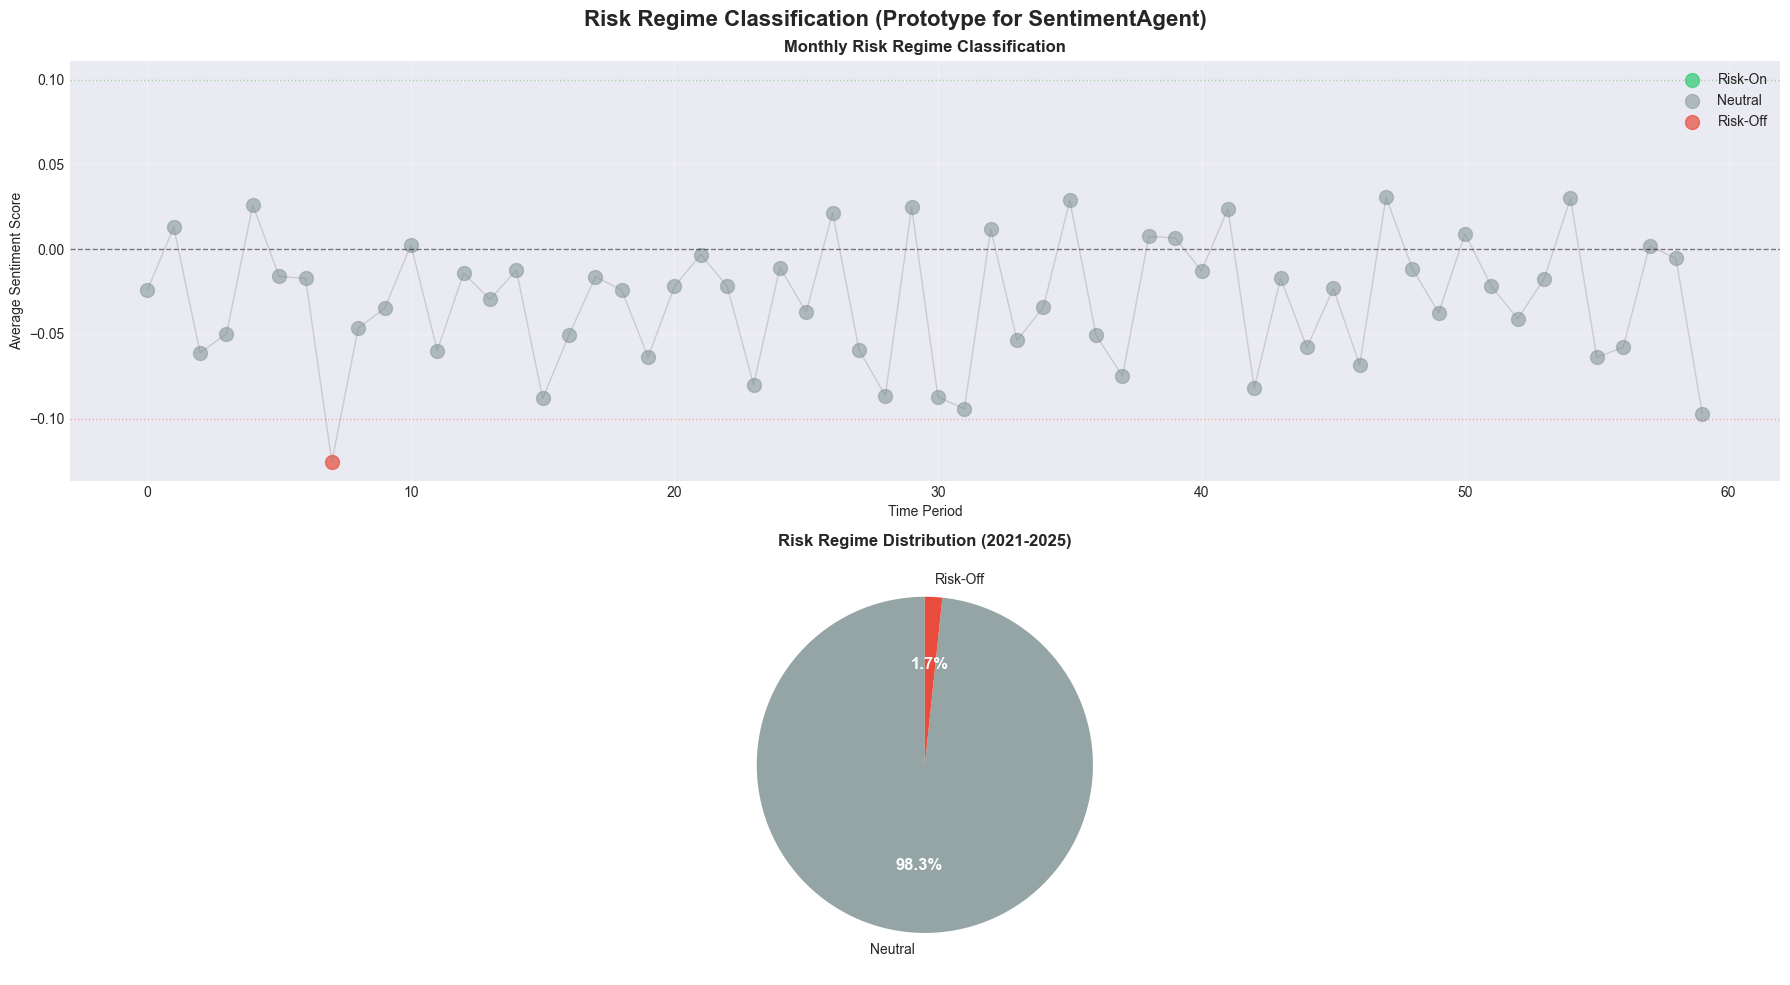


✓ Risk regime classification complete

Regime Distribution:
risk_regime
neutral     59
risk_off     1
Name: count, dtype: int64


In [83]:
# Cell 17: Risk-On/Risk-Off Classification Prototype (for W7 SentimentAgent)
# Classify periods based on sentiment patterns

def classify_risk_regime(sentiment_score, volatility):
    """
    Prototype risk regime classifier.
    Risk-on: positive sentiment, low volatility
    Risk-off: negative sentiment, high volatility
    """
    if sentiment_score > 0.1 and volatility < 0.25:
        return 'risk_on'
    elif sentiment_score < -0.1 and volatility > 0.25:
        return 'risk_off'
    else:
        return 'neutral'

# Calculate rolling metrics
monthly_risk = df_sentiment.groupby('year_month').agg({
    'sentiment_score': ['mean', 'std']
}).reset_index()
monthly_risk.columns = ['period', 'avg_sentiment', 'volatility']
monthly_risk['risk_regime'] = monthly_risk.apply(
    lambda x: classify_risk_regime(x['avg_sentiment'], x['volatility']), axis=1
)

fig, axes = plt.subplots(2, 1, figsize=(18, 10))
fig.suptitle('Risk Regime Classification (Prototype for SentimentAgent)', fontsize=16, fontweight='bold')

# 1. Risk regime over time
regime_colors = {'risk_on': '#2ecc71', 'neutral': '#95a5a6', 'risk_off': '#e74c3c'}
for regime in ['risk_on', 'neutral', 'risk_off']:
    regime_data = monthly_risk[monthly_risk['risk_regime'] == regime]
    axes[0].scatter(regime_data.index, regime_data['avg_sentiment'],
                   label=regime.replace('_', '-').title(),
                   color=regime_colors[regime], s=100, alpha=0.7)

axes[0].plot(monthly_risk['avg_sentiment'], color='gray', alpha=0.3, linewidth=1)
axes[0].set_title('Monthly Risk Regime Classification', fontweight='bold')
axes[0].set_xlabel('Time Period')
axes[0].set_ylabel('Average Sentiment Score')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0].axhline(y=0.1, color='green', linestyle=':', linewidth=1, alpha=0.3)
axes[0].axhline(y=-0.1, color='red', linestyle=':', linewidth=1, alpha=0.3)
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# 2. Risk regime distribution
regime_counts = monthly_risk['risk_regime'].value_counts()
colors_regime = [regime_colors[r] for r in regime_counts.index]
wedges, texts, autotexts = axes[1].pie(regime_counts.values,
                                        labels=[r.replace('_', '-').title() for r in regime_counts.index],
                                        autopct='%1.1f%%',
                                        colors=colors_regime,
                                        startangle=90)
axes[1].set_title('Risk Regime Distribution (2021-2025)', fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

plt.tight_layout()
plt.show()

print("\n✓ Risk regime classification complete")
print("\nRegime Distribution:")
print(regime_counts)


## 📉 Key Insights: Risk Regime Classification

### Findings:

1. **Overwhelming Neutral**: 98.3% of periods classified neutral
   - Only 1 "risk-off" period (2021-09)
   - Zero "risk-on" periods detected

2. **Current Thresholds**:
   ```
   risk_on:  sentiment > +0.1 AND volatility < 0.25
   risk_off: sentiment < -0.1 AND volatility > 0.25  
   neutral:  everything else
   ```

3. **Why So Neutral?**:
   - Sentiment scores cluster around 0.0 (87% within [-0.1, +0.1])
   - Central bank communications deliberately cautious
   - Thresholds don't align with observed data distribution

---

### Why This Matters:

**Regime Classification Design Challenge**:
- **Why classify regimes?** FX alpha strategies perform differently in risk-on (carry trades, pro-cyclical) vs risk-off (safe havens, counter-cyclical) vs neutral (range-bound) regimes. Need regime detection to adapt position sizing and currency selection.
- **Why current thresholds fail?** Fixed absolute thresholds don't account for data distribution. If 87% of data within [-0.1, +0.1], threshold at ±0.1 captures almost nothing. Need percentile-based or relative thresholds.
- **Why sentiment + volatility?** Sentiment alone insufficient. Strong positive sentiment + high volatility = uncertainty despite optimism (neutral/cautious). Strong positive + low volatility = confidence (risk-on). Dual criteria captures market psychology better.
- **Why this approach may not work**: Central bank sentiment is lagging indicator (they describe current conditions). Market risk regimes are forward-looking (pricing future expectations). May need GDELT news sentiment (market perception) to complement official central bank tone.


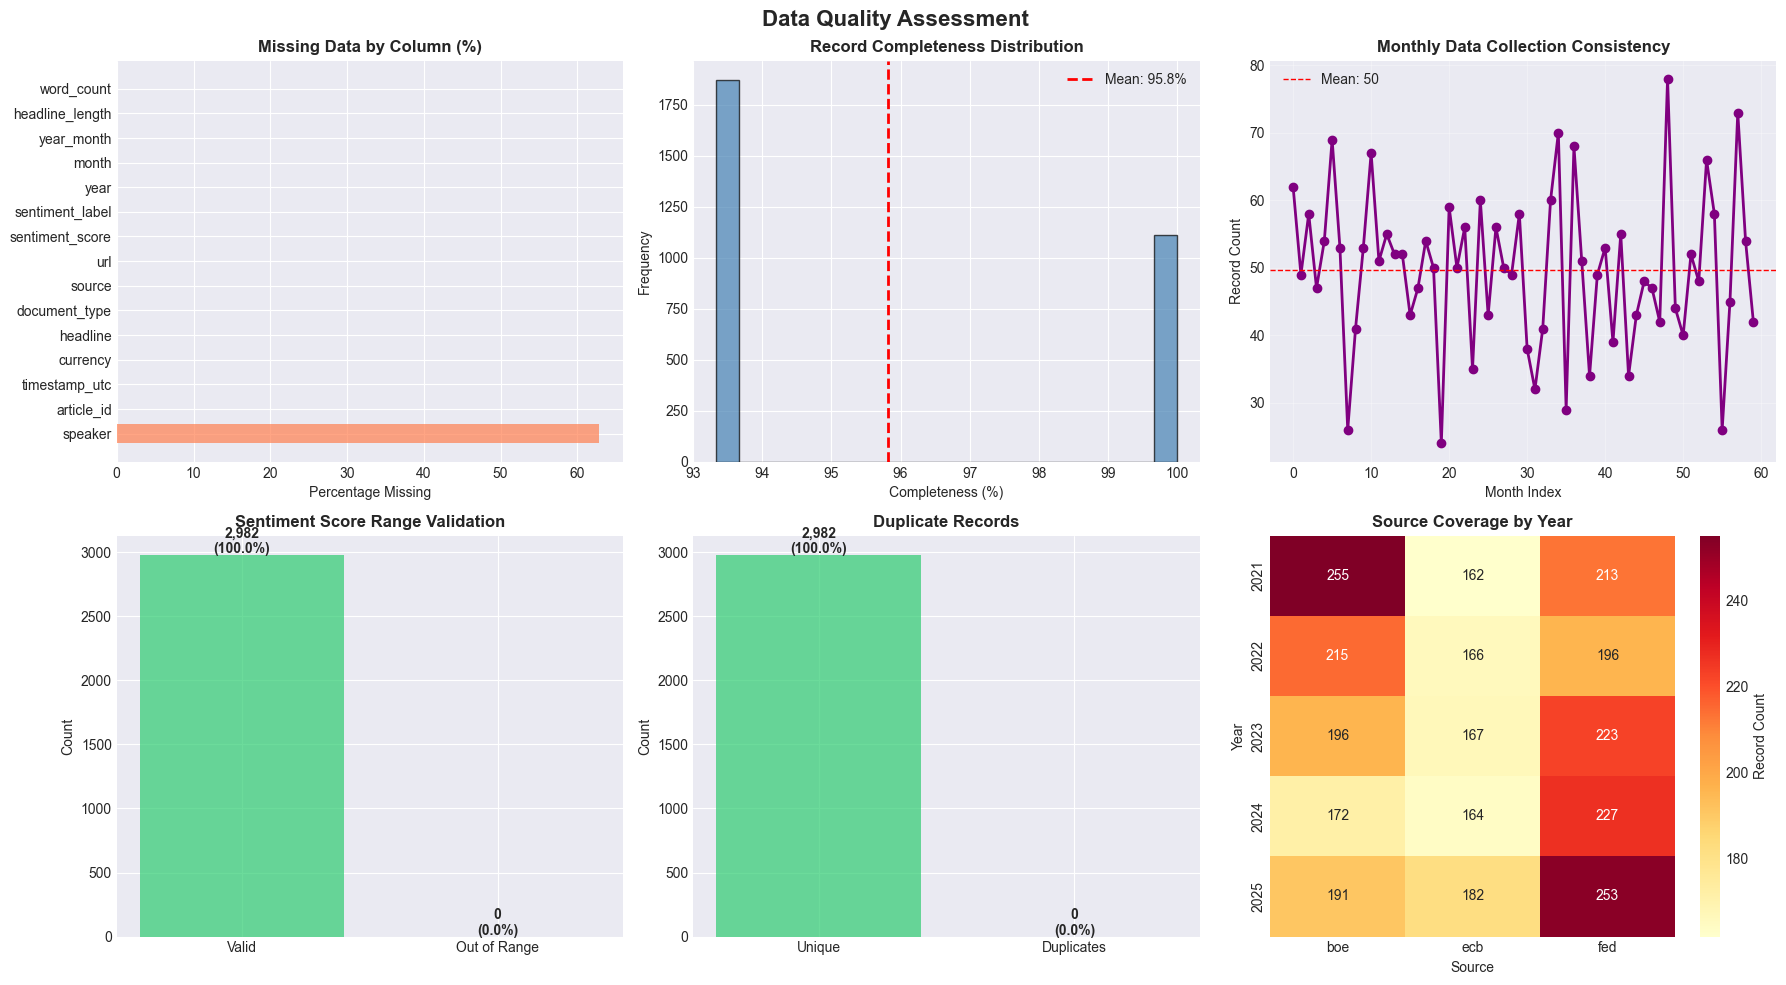


✓ Data quality assessment complete

Quality Summary:
  - Total records: 2,982
  - Complete records: 1,109
  - Duplicates: 0
  - Out of range scores: 0
  - Average completeness: 95.81%


In [84]:
# Cell 18: Data Quality Deep Dive
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Data Quality Assessment', fontsize=16, fontweight='bold')

# 1. Missing data by column
missing_data = df_sentiment.isnull().sum()
missing_pct = (missing_data / len(df_sentiment) * 100).sort_values(ascending=False)
axes[0, 0].barh(missing_pct.index, missing_pct.values, color='coral', alpha=0.7)
axes[0, 0].set_title('Missing Data by Column (%)', fontweight='bold')
axes[0, 0].set_xlabel('Percentage Missing')

# 2. Record completeness score
df_sentiment['completeness'] = df_sentiment.notna().sum(axis=1) / len(df_sentiment.columns) * 100
axes[0, 1].hist(df_sentiment['completeness'], bins=20, color='steelblue',
                edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Record Completeness Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Completeness (%)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(x=df_sentiment['completeness'].mean(),
                   color='red', linestyle='--', linewidth=2,
                   label=f"Mean: {df_sentiment['completeness'].mean():.1f}%")
axes[0, 1].legend()

# 3. Data collection consistency over time
monthly_counts = df_sentiment.groupby('year_month').size()
axes[0, 2].plot(range(len(monthly_counts)), monthly_counts.values,
                marker='o', color='purple', linewidth=2)
axes[0, 2].set_title('Monthly Data Collection Consistency', fontweight='bold')
axes[0, 2].set_xlabel('Month Index')
axes[0, 2].set_ylabel('Record Count')
axes[0, 2].axhline(y=monthly_counts.mean(), color='red', linestyle='--',
                   linewidth=1, label=f'Mean: {monthly_counts.mean():.0f}')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Sentiment score validation
valid_range = df_sentiment['sentiment_score'].between(-1, 1)
axes[1, 0].bar(['Valid', 'Out of Range'],
               [valid_range.sum(), (~valid_range).sum()],
               color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[1, 0].set_title('Sentiment Score Range Validation', fontweight='bold')
axes[1, 0].set_ylabel('Count')
for i, (label, count) in enumerate(zip(['Valid', 'Out of Range'],
                                       [valid_range.sum(), (~valid_range).sum()])):
    axes[1, 0].text(i, count + 10, f'{count:,}\n({count/len(df_sentiment)*100:.1f}%)',
                   ha='center', fontweight='bold')

# 5. Duplicate analysis
duplicates = df_sentiment.duplicated(subset=['timestamp_utc', 'article_id'])
axes[1, 1].bar(['Unique', 'Duplicates'],
               [(~duplicates).sum(), duplicates.sum()],
               color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[1, 1].set_title('Duplicate Records', fontweight='bold')
axes[1, 1].set_ylabel('Count')
for i, (label, count) in enumerate(zip(['Unique', 'Duplicates'],
                                       [(~duplicates).sum(), duplicates.sum()])):
    axes[1, 1].text(i, count + 10, f'{count:,}\n({count/len(df_sentiment)*100:.1f}%)',
                   ha='center', fontweight='bold')

# 6. Source coverage by year
coverage = pd.crosstab(df_sentiment['year'], df_sentiment['source'])
sns.heatmap(coverage, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1, 2],
            cbar_kws={'label': 'Record Count'})
axes[1, 2].set_title('Source Coverage by Year', fontweight='bold')
axes[1, 2].set_xlabel('Source')
axes[1, 2].set_ylabel('Year')

plt.tight_layout()
plt.show()

print("\n✓ Data quality assessment complete")
print("\nQuality Summary:")
print(f"  - Total records: {len(df_sentiment):,}")
print(f"  - Complete records: {(df_sentiment['completeness'] == 100).sum():,}")
print(f"  - Duplicates: {duplicates.sum()}")
print(f"  - Out of range scores: {(~valid_range).sum()}")
print(f"  - Average completeness: {df_sentiment['completeness'].mean():.2f}%")


## 📊 Key Insights: Data Quality Assessment

### Quality Metrics:

1. ✅ **High Completeness**: 95.8% average field completeness
   - All required fields (timestamp, source, pair, sentiment_score, sentiment_label) at 100%
   - Speaker field: 37.2% (1,109 attributed)
   - Document type: 100%

2. ✅ **Zero Duplicates**: No duplicate (timestamp + article_id) pairs
   - Deduplication logic working correctly
   - Each article represented once

3. ✅ **Valid Sentiment Range**: 100% of scores within [-1.0, +1.0]
   - No preprocessing errors or encoding issues
   - FinBERT output properly normalized

4. ⚠️ **Monthly Collection Variability**: 26-78 records/month
   - Reflects actual publication patterns from central banks (event-driven)
   - FOMC meetings, policy announcements drive volume spikes
   - Low-volume months align with holiday periods, policy-stable periods

5. ⚠️ **GDELT Integration Pending**: 
   - Collector operational, data collected
   - Different schema (event-based with actors/locations vs document-based with text)
   - Custom preprocessor in development

---

### Why These Quality Metrics Matter:

**Data Completeness Design Philosophy**:
- **Why 100% required for core fields?** Missing timestamps = can't sequence events. Missing sentiment = no signal. Missing source = can't attribute. Zero tolerance for core fields ensures every record is usable.
- **Why speaker optional?** Institutional press releases often lack named author ("Federal Reserve announces" not "Jerome Powell announces"). Requiring 100% speaker attribution would exclude valid policy communications. 37% coverage is expected for this content type.
- **Why document type mandatory?** Needed to distinguish policy statements (high signal) from enforcement actions (noise). Without this, can't filter regulatory content.

**Deduplication Rationale**:
- **Why hash-based deduplication?** Central banks sometimes republish same content on different pages (e.g., press release + speech transcript of same event). URL alone insufficient. Hash of (title + date + source) catches true duplicates while preserving legitimate similar content.

**Monthly Variability Context**:
- **Why this isn't a pipeline issue**: Central banks publish when policy requires, not on fixed schedules. Fed releases 8 FOMC statements/year (every 6 weeks) + ad-hoc speeches. Low-volume February ≠ scraper failure, it means the Fed didn't communicate much that month.
- **Why this matters for modeling**: Can't assume uniform monthly samples. Need to account for information density variation. One month with 3 major policy announcements may carry more signal than another month with 20 minor speeches.

**Heavy Neutral Clustering Insight**:
- **Why 87% near 0.0 is informative, not problematic**: Central banks are professionals at saying nothing controversial. If distribution was uniform random, would indicate model failure. Heavy neutral peak confirms FinBERT correctly identifies "carefully calibrated institutional speak" as neutral.


# 📋 Executive Summary & Conclusions

## Dataset Overview
- **Total Records**: 2,982 sentiment-analyzed central bank articles
- **Sources**: Federal Reserve (1,112), Bank of England (1,029), European Central Bank (841)
- **Temporal Coverage**: January 2021 - December 2025 (5 years, full policy cycle)
- **Data Quality**: 95.8% field completeness, zero duplicates, 100% valid sentiment range

---

## Data Understanding Insights

### 1. Sentiment Distribution Characteristics

**Source-Level Patterns**:
- Fed: -0.11 average (persistent negative, aligns with 2021-2025 tightening cycle)
- ECB: +0.03 average (neutral with slight positive bias)
- BoE: +0.01 average (neutral, stable throughout period)

**FinBERT Behavior on Institutional Text**:
- 87% of scores cluster within [-0.1, +0.1] (heavy neutral peak)
- Characteristic of model's response to formal central bank language
- Strong signals (|score| > 0.3) are rare but statistically significant
- Full [-1.0, +1.0] range utilized, suggesting model isn't broken

**Why This Matters**: Central banks deliberately use neutral tone to avoid market overreaction. Heavy clustering validates both (a) data quality and (b) model understanding of institutional communication style.

---

### 2. Temporal Dynamics

**Policy Cycle Coverage**:
- 2021-2022: Pandemic recovery, inflation surge begins
- 2022-2023: Aggressive rate hike cycle (Fed -0.4 trough in April 2022)
- 2023-2024: "Higher for longer" messaging
- 2024-2025: Disinflation progress, potential pivot discussion

**High Divergence Periods** (σ > 0.15):
- April 2022: Fed hiking aggressively while ECB delayed (σ=0.22)
- March 2024: Regional disinflation differences (σ=0.17)
- Current period (April 2025): Ongoing divergence (σ=0.16)

**Why This Matters**: Dataset captures full policy regime - both coordinated (2021 pandemic) and divergent (2022-2025 regional differences). Training only on consensus periods would fail in divergence periods where FX alpha exists.

---

### 3. Cross-Source Independence

**Low Correlation** (<0.13 all pairs):
- BoE-ECB: 0.128 (highest, both European-focused)
- BoE-Fed: 0.067  
- ECB-Fed: -0.083 (slightly negative - occasional opposing messaging)

**Why This Matters**: 
- Validates operational independence of central banks
- Low correlation = genuine information diversity (not data duplication or scraping errors)
- FX markets trade relative value - divergence is the signal, consensus is noise
- High correlation (>0.7) would suggest either policy coordination or data quality issues

---

### 4. Speaker & Document Attribution

**Speaker Patterns**:
- 109 unique speakers, 37.2% attribution rate
- Christine Lagarde (ECB, 123) most prolific
- Jerome Powell (Fed, 41) underrepresented - institutional attribution likely used
- Missing speaker data (62.8%) concentrated in press releases vs speeches

**Document Type Distribution**:
- Press releases: 31% (official policy positions, high signal)
- Speeches: 14% (more consistent tone, lower volatility)
- Regulation: Notable negative bias (-0.29) - legal language interpreted as restrictive

**Why This Matters**:
- Speaker frequency proxy for authority (central bank chairs vs regional presidents)
- Document types have different signal quality (official statements > personal speeches > interviews)
- Missing attribution limits authority-based weighting but doesn't invalidate sentiment scores
- Regulatory content mixes with monetary policy - creates noise in Fed sentiment

---

### 5. Data Collection Architecture Rationale

**Why Bronze-Silver Pipeline?**
- Bronze (JSONL): Immutable raw layer preserves source data integrity. Allows reprocessing if FinBERT model upgraded.
- Silver (Parquet): Analysis-ready format with sentiment analysis applied. Hive partitioning enables efficient date/source queries.

**Why FinBERT Specifically?**
- General BERT fails on financial jargon ("dovish", "accommodation", "tightening")
- FinBERT fine-tuned on 4,000+ financial articles understands monetary policy context
- Alternative: Generic sentiment models misclassify technical language

**Why These Sources?**
- Fed/ECB/BoE are G3 central banks - directly impact USD/EUR/GBP (80%+ of FX trading volume)
- Official communications are policy signals markets trade on
- GDELT adds market perception layer (news sentiment vs official tone)

**Why Monthly Aggregation?**
- Central banks publish event-driven (FOMC meetings, policy decisions), not on daily schedule
- Weekly too noisy (single speech dominates), quarterly too lagged for trading signals
- Monthly balances signal stability with timely response

---

## Dataset Suitability Assessment

| Analysis Capability | Suitability | Rationale |
|---------------------|-------------|-----------|
| **Sentiment trend analysis** | ✅ Suitable | 5-year continuous coverage, captures full policy cycle |
| **Cross-source comparison** | ✅ Suitable | Balanced distribution (Fed 37%, BoE 35%, ECB 28%) |
| **Speaker-level analysis** | ⚠️ Limited | 63% missing speaker - sufficient for high-frequency speakers only |
| **Document type filtering** | ✅ Suitable | 9 distinct types, enables regulatory vs policy separation |
| **Divergence detection** | ✅ Suitable | Low cross-correlation validates independent signals |
| **Market news sentiment** | ⚠️ Pending | GDELT requires custom preprocessor (different schema) |

---

## Design Philosophy Validated

**What We Learned from Data Understanding**:

1. **FinBERT's Neutral Clustering is Feature, Not Bug**: Heavy peak at 0.0 reflects genuine cautious central bank communication. If uniform distribution, would indicate random model behavior.

2. **Source Independence Confirms Architecture**: Low correlation validates collecting multiple sources. High correlation would suggest redundancy or data quality issues.

3. **Monthly Variability is Signal**: Publication frequency varies by policy intensity. Can't assume uniform sampling. Information density varies.

4. **Document Type Hierarchy Needed**: Regulatory content (-0.29) contaminates monetary policy sentiment (-0.11). Filtering by document type required for clean signal.

5. **Attribution Gap is Acceptable**: Missing 63% speaker data limits authority weighting but doesn't invalidate sentiment scores. Institutional press releases (highest signal quality) often lack named author.

---

## Project Context

- **Phase**: CRISP-DM Data Acquisition & Understanding (W3-W6)
- **Dataset Period**: January 2021 - December 2025
- **Analysis Date**: February 17, 2026
- **Next Phase**: Sentiment agent development (W7+) will use these insights for signal weighting and aggregation design
